In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM  # WMAP9 as cosmo
from astropy.cosmology import z_at_value

from scipy.integrate import trapezoid as trapz
from scipy.interpolate import interpn
from scipy.misc import derivative
from scipy.stats import norm

from IPython.display import display, Math

from sammbhb import quasar_based as qb

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
context = 'paper'
sns.set_context(context, font_scale=2)
sns.set_style('ticks')
sns.set_palette('colorblind')
rcparams = {
    # 'font.family': 'DejaVu Sans',
    # 'font.serif':'Times',
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'text.usetex': False,
    # 'figure.figsize': (12.8, 9.6),
    'xtick.direction': 'in',
    'xtick.top': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in'
}
plt.rcParams.update(rcparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
div_cmap = sns.color_palette("vlag", as_cmap=True)

In [4]:
QUANTILES = [.16, .5, .84]

In [5]:
SCHECHTER = True

N_AXIS_SAMPLES = 2 ** 5
display(Math('$N_{{\mathrm{{axis}}}} = {0}'.format(N_AXIS_SAMPLES)))

<IPython.core.display.Math object>

In [6]:
# model bounds
LOG_M_MIN = 8
LOG_M_MAX = 10.5

Z_MIN = 0
Z_MAX = 1.5

Q_MIN = .25
Q_MAX = 1

LOG_LBOL_MIN = 45
LOG_LBOL_MAX = 48

In [7]:
Z_MIN_CRTS = .036
Z_MAX_CRTS = 2.672

In [8]:
# Used for plotting
# LOG_M_MIN = LOG_M_MIN
# LOG_M_MAX = 10.5

In [9]:
Z_LOCAL_M04 = .3  # local range of Marconi+ 2004

In [10]:
Z_LOCAL_V09_MIN = .013  # local range of Vika+ 2009
Z_LOCAL_V09_MAX = .18

In [11]:
# first we initialize the space we want to sample our models over
log_lbol_range = np.linspace(LOG_LBOL_MIN, LOG_LBOL_MAX, num=int(N_AXIS_SAMPLES)+1)  # lower bound matched to Graham et al. (2015)
log_mtot_range = np.linspace(LOG_M_MIN, LOG_M_MAX, num=int(N_AXIS_SAMPLES))  # approx. match to Siyuan's models, with lower cutoff
# log_mtot_range = np.append(log_mtot_range, 9) if 9 not in log_mtot_range else log_mtot_range
log_mtot_range = np.sort(log_mtot_range)

z_range = np.linspace(Z_MIN, Z_MAX, num=int(N_AXIS_SAMPLES))  # Matching SMBHB limits
# z_range = np.append(z_range, Z_LOCAL_M04) if Z_LOCAL_M04 not in z_range else z_range
# z_range = np.append(z_range, Z_LOCAL_V09_MIN) if Z_LOCAL_V09_MIN not in z_range else z_range
# z_range = np.append(z_range, Z_LOCAL_V09_MAX) if Z_LOCAL_V09_MAX not in z_range else z_range
# z_range = np.append(z_range, .25) if .25 not in z_range else z_range
z_range = np.sort(z_range)

q_range = np.linspace(Q_MIN, Q_MAX, num=int(N_AXIS_SAMPLES)-1)  # temporarily reducing the number of samples for speed/debugging

In [12]:
def heatmap(x, y, z, x_marg, y_marg, ax, ax_xmarg, ax_ymarg, axins=None, vmin=None, vmax=None, cmap='flare_r', dashed=False):
    # no labels
    ax_xmarg.tick_params(axis="x", labelbottom=False)
    ax_ymarg.tick_params(axis="y", labelleft=False)

    # the heatmap:
    xx, yy = np.meshgrid(x, y, indexing='ij')
    pcm = ax.pcolormesh(xx, yy, z, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
    
    if axins is not None:
        axins.pcolormesh(xx, yy, z, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
        axins.set_xlim(9, 10.5)
        axins.set_ylim(0, .25)
    
    # the histograms
    if dashed:
        ax_xmarg.plot(x, x_marg[1], color=cs[0])
        ax_xmarg.plot(x, x_marg[0], linestyle='--', color=cs[0])
        ax_xmarg.plot(x, x_marg[2], linestyle='--', color=cs[0])
        ax_xmarg.fill_between(x, -1, x_marg[1], alpha=.2, color=cs[0])
        
        ax_ymarg.plot(y_marg[1], y, color=cs[0])
        ax_ymarg.plot(y_marg[0], y, linestyle='--', color=cs[0])
        ax_ymarg.plot(y_marg[2], y, linestyle='--', color=cs[0])
        ax_ymarg.fill_betweenx(y, -1, y_marg[1], alpha=.2, color=cs[0])
    else:
        ax_xmarg.plot(x, x_marg[1], color=cs[0])
        ax_xmarg.fill_between(x, x_marg[0], x_marg[2], alpha=.2, color=cs[0])
        ax_ymarg.plot(y_marg[1], y, color=cs[0])
        ax_ymarg.fill_betweenx(y, y_marg[0], y_marg[2], alpha=.2, color=cs[0])
    return pcm

# Mass functions

## BHMF

In [13]:
def log_mgal_to_log_mbulge(log_mgal):
    r"""Convert from galaxy mass to bulge mass.
    
    Follows the conversion from Chen, Sesana, and Conselice 2019.
    
    Parameters
    ----------
    log_mgal : float or array_like of float
        The base-10 logarithm of galaxy mass in solar masses.
        
    Returns
    -------
    log_mbulge : float or array_like of float
        The base-10 logarithm of bulge mass in solar masses.
    
    """
    factor = 0.615 + np.where(log_mgal > 10, np.sqrt(6.9) 
                              / ((log_mgal - 10) ** 1.5) 
                              * np.exp(-3.45 / (log_mgal - 10)), 0)
    
    return log_mgal + np.log10(factor)


def log_mbulge_to_log_mbh(log_mbulge, log_norm, slope):
    r"""Convert from bulge mass to black hole mass.
    
    Parameters
    ----------
    log_mbulge : float or array_like of float
        The base-10 logarithm of bulge mass in solar masses.
    log_norm : float or array_like of float
        Base-10 logarithm of the power-law normalization.
    slope : float or array_like of float
        Power-law slope.
        
    Returns
    -------
    log_mbh : float or array_like of float
        The base-10 logarithm of black hole mass in solar masses.
    
    """
    return log_norm + slope * log_mbulge

In [14]:
# McConnell & Ma 2013 M_BH - M_bulge relation
slope_mm13 = 1.05
log_norm_mm13 = 8.46 - slope_mm13 * 11

# Kormendy & Ho 2013 M_BH - M_bulge relation
slope_kh13 = 1.17
log_norm_kh13 = 9 + np.log10(.49) - slope_kh13 * 11

In [15]:
# Sampling space of Siyuan's models
log_mgal_c19 = np.linspace(10.5, 12, 25)
log_m_chirp_c19 = np.linspace(5, 11, 30)

q_gal_c19 = np.linspace(.25, 1, 10)
q_bhb_c19 = np.linspace(0, 1, 10)

z_c19 = np.linspace(0, 1.5, 5)

In [16]:
log_mbulge_c19 = log_mgal_to_log_mbulge(log_mgal_c19)
log_mbh_c19_mm13 = log_mbulge_to_log_mbh(log_mbulge_c19, log_norm_mm13, slope_mm13)
log_mbh_c19_kh13 = log_mbulge_to_log_mbh(log_mbulge_c19, log_norm_kh13, slope_kh13)

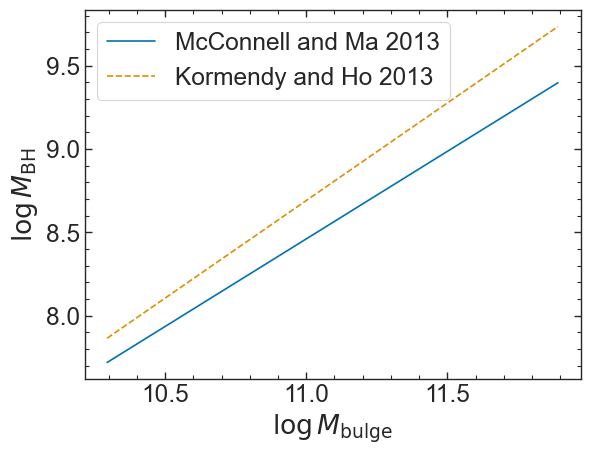

In [17]:
plt.figure()
plt.plot(log_mbulge_c19, log_mbh_c19_mm13, label='McConnell and Ma 2013', linestyle='-')
plt.plot(log_mbulge_c19, log_mbh_c19_kh13, label='Kormendy and Ho 2013', linestyle='--')
plt.xlabel(r'$\log M_{\rm{bulge}}$')
plt.ylabel(r'$\log M_{\rm{BH}}$')
plt.legend()
    
plt.show()

### GSMF

In [18]:
def load_gsmf(filename):
    with open(filename, 'rb') as f:
        gsmf = np.load(f)

    gsmf = np.moveaxis(gsmf, [0, 2], [-1, -2])  # shifting axes from mc-m-q-z to m-z-q-mc to match other samples
    # gsmf = np.sum(gsmf, axis=2)  # sum over the q axis to get rid of it
    return gsmf


def load_log_mbh(filename):
    with open(filename, 'rb') as f:
        log_mbh = np.load(f)

    log_mbh = np.moveaxis(log_mbh, [0], [-1])  # shifting axes from mc-m to m-mc to match other samples
    return log_mbh


def m_gal_to_m_bulge(m_gal):
    m_gal = np.array(m_gal)
    log_m_gal = np.log10(m_gal)
    
    scale = 0.615
    add_scale = np.where(log_m_gal <= 10,
                         0,
                         np.sqrt(6.9) 
                         / ((log_m_gal - 10) ** 1.5) 
                         * np.exp(-3.45 / (log_m_gal - 10)))
    scale = scale + add_scale
        
    return scale * m_gal


def log_m_gal_to_log_m_bulge(log_m_gal):
    m_gal = 10 ** log_m_gal
    
    m_bulge = m_gal_to_m_bulge(m_gal)
    log_m_bulge = np.log10(m_bulge)
    
    return log_m_bulge


def dlog_m_bulge_over_dlog_m_gal(log_m_gal):
    return derivative(log_m_gal_to_log_m_bulge, log_m_gal, dx=1e-6)


def log_m_bulge_to_log_m_bh(log_m_bulge, slope=1, intercept=8):
    log_m_bulge = np.array(log_m_bulge) - 11
    slope = np.array(slope)
    intercept = np.array(intercept)
    
    try:
        log_m_bh = intercept + slope * log_m_bulge
    except:
        log_m_bh = intercept + slope * log_m_bulge[..., np.newaxis]
        
    return log_m_bh


def P_log_m_bh(log_mbh, log_m_bulge, slope=1, intercept=8, scatter=.29):
    """Calculate the probability of having a BH mass given a bulge mass.
    
    """
    log_mbh_loc = log_m_bulge_to_log_m_bh(log_m_bulge, slope=slope, intercept=intercept)  # BH mass centroid
    
    try:
        prob = norm.pdf(log_mbh, loc=log_mbh_loc, scale=scatter)
    except:
        prob = norm.pdf(log_mbh[..., np.newaxis], loc=log_mbh_loc, scale=scatter)
    
    return prob


def gsmf_to_bulgemf(gsmf, log_m_gal):
    """Convert galaxy stellar mass function to bulge mass function.
    
    Parameters
    ----------
    gsmf : array_like of float
        The galaxy stellar mass function. The first axis is assumed to be sampled over galaxy stellar mass.
    log_m_gal : float or array_like of float
        Base-10 logarithm of galaxy stellar masses corresponding to point GSMF is sampled
        
    Returns
    -------
    bulgemf : array_like of float
        The bulge mass function
    log_m_bulge : float or array_like of float
        The bulge_mass_coordinates of the samples
    
    """
    gsmf = np.array(gsmf)
    dlog_m_bulge_dlog_m_gal = dlog_m_bulge_over_dlog_m_gal(log_m_gal)
    
    while dlog_m_bulge_dlog_m_gal.ndim < gsmf.ndim:
        dlog_m_bulge_dlog_m_gal = dlog_m_bulge_dlog_m_gal[..., np.newaxis]
        
    bulgemf = gsmf * dlog_m_bulge_dlog_m_gal
    
    log_m_bulge = log_m_gal_to_log_m_bulge(log_m_gal)
    
    return bulgemf, log_m_bulge


def bulgemf_to_bhmf(bulgemf, log_m_bulge, log_mbh, slope=1, intercept=8, scatter=.29):
    """Convolve the bulge mass function to get a BHMF.
    
    Parameters
    ----------
    bulgemf : array_like of float
        The bulge mass function. The bulge mass should be sampled along the first (0th) axis.
    log_m_bulge : array_like of float
        Bulge masses the bulge mass function is sampled at
    log_mbh : array_like of float
        BH masses to sample the BHMF at
    slope : float or array_like of float
        M_BH - M_bulge slope
    intercept : float or array_like of float
        M_BH - M_bulge intercept
    scatter : float
        M_BH - M_bulge intrinsic scatter
    
    """
    if scatter is None or scatter == 0:
        try:
            bhmf = bulgemf / slope
        except:
            bhmf = bulgemf[..., np.newaxis] / slope
        
        return bhmf
        
    mm_bh, mm_bulge = np.meshgrid(log_mbh, log_m_bulge, indexing='ij')
    
    prob = P_log_m_bh(mm_bh, mm_bulge,
                      slope=slope, 
                      intercept=intercept, 
                      scatter=scatter)
    
    bulgemf = bulgemf[np.newaxis, ...]
    
    if prob.ndim == 2:
        while prob.ndim < bulgemf.ndim:
            prob = prob[..., np.newaxis]
    else:
        while prob.ndim < bulgemf.ndim:
            prob = prob[..., np.newaxis, :]
    
    integ = bulgemf * prob
    bhmf = trapz(integ, log_m_bulge, axis=1)
    
    return bhmf


def gsmf_to_bhmf(gsmf, log_m_gal, log_mbh, slope=1, intercept=8, scatter=None):
    """Convert the galaxy stellar mass function to a black hole mass function.
    
    """
    bulgemf, log_m_bulge = gsmf_to_bulgemf(gsmf, log_m_gal)
    
    bhmf = bulgemf_to_bhmf(bulgemf, log_m_bulge, log_mbh, 
                               slope=slope, intercept=intercept, scatter=scatter)
    return bhmf

In [19]:
gsmf = load_gsmf('../data/external/chen19/combined_gsmf/combined_m_bh_m_bulge/phi_g.npy')
# gsmf = load_gsmf('../data/external/chen19/combined_gsmf/mm13/phi_g.npy')
gsmf.shape

(25, 5, 10, 1000)

### $M_{\rm BH} - M_{\rm bulge}$ Scaling

In [20]:
with open('../data/external/comb/samples.dat', 'rb') as f:
        samples = np.loadtxt(f).T

print(samples.shape)
slope = samples[-3]
intercept = samples[-4]

(17, 1000)


In [21]:
# Corresponding BH masses
log_mbh_combo_combo = load_log_mbh('../data/external/chen19/combined_gsmf/combined_m_bh_m_bulge/mbh.npy')
# log_mbh_combo_combo = load_log_mbh('../data/external/chen19/combined_gsmf/mm13/mbh.npy')
log_mbh_combo_combo_q = np.quantile(log_mbh_combo_combo, q=QUANTILES, axis=-1)
log_mbh_combo_combo_err = np.diff(log_mbh_combo_combo_q, axis=0)

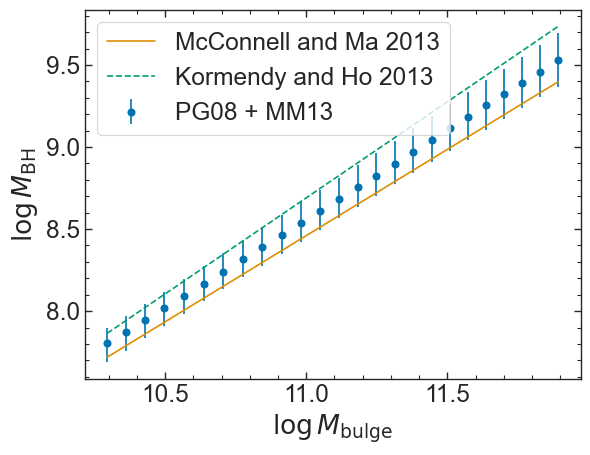

In [22]:
plt.figure()
plt.errorbar(log_mbulge_c19, log_mbh_combo_combo_q[1],
             yerr=log_mbh_combo_combo_err, fmt='o', label='PG08 + MM13')
plt.plot(log_mbulge_c19, log_mbh_c19_mm13, label='McConnell and Ma 2013', linestyle='-')
plt.plot(log_mbulge_c19, log_mbh_c19_kh13, label='Kormendy and Ho 2013', linestyle='--')
plt.xlabel(r'$\log M_{\rm{bulge}}$')
plt.ylabel(r'$\log M_{\rm{BH}}$')
plt.legend()
    
plt.show()

In [23]:
def q_gal_to_q_bhb(q_gal, log_mbh, log_mbulge):
    slope = np.gradient(log_mbh, log_mbulge, axis=0)[0]
    q_bhb = q_gal[:, np.newaxis] ** slope
    return q_bhb

In [24]:
bhmf = gsmf_to_bhmf(gsmf, log_mgal_c19, log_mtot_range, slope=slope, intercept=intercept, scatter=.29)
bhmf.shape

(32, 5, 10, 1000)

In [25]:
bhmf_no_scatter = gsmf_to_bhmf(gsmf, log_mgal_c19, log_mtot_range, slope=slope, intercept=intercept, scatter=None)
bhmf_no_scatter.shape

(25, 5, 10, 1000)

## BHBMF

In [26]:
def load_bhbmf(filename):
    with open(filename, 'rb') as f:
        bhbmf = np.load(f)

    bhbmf = np.moveaxis(bhbmf, [0, 2], [-1, -2])  # shifting axes from mc-m-q-z to m-z-q-mc to match other samples
    # gsmf = np.sum(gsmf, axis=2)  # sum over the q axis to get rid of it
    return bhbmf

In [27]:
# Next we load the sampled SMBHB mass function (SMBHBMF). Note that
# unlike our other models, which are analytic, here we plan to
# interpolate over the sampled SMBHBMF to obtain our comparison
# samples. It is worth noting that for these samples the mass axis is
# over chirp mass. When we sample we will convert from total mass
# to chirp mass.
bhbmf_combo_combo = load_bhbmf('../data/external/chen19/combined_gsmf/combined_m_bh_m_bulge/nsum.npy')
# bhbmf_combo_combo = load_bhbmf('../data/external/chen19/combined_gsmf/mm13/nsum.npy')
bhbmf_combo_combo.shape

(30, 5, 10, 1000)

In [28]:
bhbmf_combo_combo_total = trapz(np.sum(bhbmf_combo_combo, axis=2), z_c19, axis=1) #/ np.power(10, log_m_chirp_c19[:, np.newaxis]) / np.log(10))
bhbmf_combo_combo_total = np.log10(bhbmf_combo_combo_total) - 2 * np.log10(0.364868)  # + 2 - np.log10(9)
bhbmf_combo_combo_total_q = np.quantile(bhbmf_combo_combo_total, q=QUANTILES, axis=-1) 

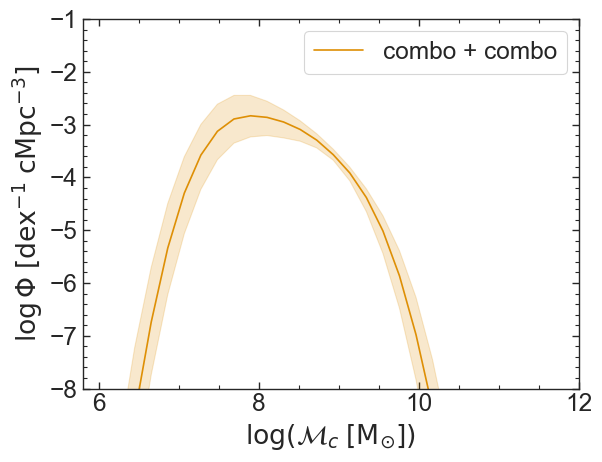

In [29]:
plt.figure()

plt.plot(log_m_chirp_c19, bhbmf_combo_combo_total_q[1], c=cs[1], ls='-', label=r'combo + combo')
plt.fill_between(log_m_chirp_c19, bhbmf_combo_combo_total_q[0], bhbmf_combo_combo_total_q[2], color=cs[1], alpha=.2)

plt.xlim(5.8, 12)
plt.ylim(-8, -1)
plt.xlabel(r'$\log (\mathcal{M}_{c} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log \Phi \; [{\rm dex^{-1} \; cMpc^{-3}}]$')
plt.legend()
plt.show()

## QMF

### Quasar Luminosity Function

We use the quasar luminosity function from Shen et al. (2020).

In [30]:
import sys
sys.path.insert(0, '../')

In [31]:
with open(r"../models/shen_qlf.pkl", "rb") as f:
    qlf = pickle.load(f)

### $\lambda_{\rm Edd} - L_{\rm bol}$ Relation

To convert the QLF to a mass function, we assume the $\lambda_{\rm Edd} - L_{\rm bol}$ relation from Nobuta et al. (2012). Here we use a version where we have re-fit their data to include uncertainties.

In [32]:
with open(r"../models/nobuta_ler_refit.pkl", "rb") as f:
    ler = pickle.load(f)

In [33]:
with open(r"../models/graham_ler.pkl", "rb") as f:
    ler_g15 = pickle.load(f)

## Binary Quasar Mass Function

Finally we import the binary quasar mass function, which we have fit to the CRTS periodic quasar sample.

In [34]:
import sys
sys.path.insert(0, '../')

In [35]:
with open(r"../models/hpc/models/bq_mpi_posterior.pkl", "rb") as f:
    crts_qlf = pickle.load(f)

# Mass Function Samples

In [36]:
mm, zz, qq = np.meshgrid(log_mtot_range, z_range, q_range, indexing='ij')
sample_points = np.array([mm, zz, qq])
sample_points = np.moveaxis(sample_points, 0, -1)

In [37]:
z_mask_m04 = np.where(z_range <= Z_LOCAL_M04)[0]

In [38]:
z_mask_v09 = np.where((Z_LOCAL_V09_MIN <= z_range) & (z_range <= Z_LOCAL_V09_MAX))[0]

## BHMF Samples

In [39]:
def sample_bhmf(bhmf, log_mbh_orig, z_orig, q_bhb_orig, new_sample_points):
    log_bhmf = np.log10(bhmf)
    try:
        log_bhmf_samples = np.array([interpn((log_mbh_orig,
                                              z_orig, q_bhb_orig[..., i]), log_bhmf[..., i],
                                             new_sample_points, bounds_error=False, fill_value=None)
                                for i in range(len(q_bhb_orig.T))])  # careful! this setup swaps axes
    except:
        log_bhmf_samples = np.array([interpn((log_mbh_orig[..., i],
                                          z_orig, q_bhb_orig[..., i]), log_bhmf[..., i],
                                         new_sample_points, bounds_error=False, fill_value=None)
                            for i in range(len(q_bhb_orig.T))])
        
    bhmf_samples = 10 ** log_bhmf_samples
    bhmf_samples = np.moveaxis(bhmf_samples, 0, -1)
    
    # remove the q axis, noting that this has been integrated in bin
    bhmf_samples = np.sum(bhmf_samples, axis=2)
    return bhmf_samples

In [40]:
q_bhb_gal_combo_combo = q_gal_to_q_bhb(q_gal_c19, log_mbh_combo_combo, log_mbulge_c19)

In [41]:
bhmf_samples_combo_combo = sample_bhmf(bhmf, log_mtot_range, 
                                       z_c19, q_bhb_gal_combo_combo, 
                                       sample_points)

bhmf_samples_combo_combo.shape

(32, 32, 1000)

In [42]:
bhmf_samples_no_scatter = sample_bhmf(bhmf_no_scatter, log_mbh_combo_combo, 
                                       z_c19, q_bhb_gal_combo_combo, 
                                       sample_points)
bhmf_samples_no_scatter.shape

(32, 32, 1000)

In [43]:
log_bhmf_combo = np.log10(bhmf_samples_combo_combo)
log_bhmf_combo_q = np.quantile(log_bhmf_combo, q=QUANTILES, axis=-1)

In [44]:
log_bhmf_no_scatter = np.log10(bhmf_samples_no_scatter)
log_bhmf_no_scatter_q = np.quantile(log_bhmf_no_scatter, q=QUANTILES, axis=-1)

In [45]:
# marginalize over redshift
log_bhmf_mbh_combo_combo = np.log10(trapz(bhmf_samples_combo_combo, z_range, axis=1))

# quantile
log_bhmf_mbh_combo_combo_q = np.quantile(log_bhmf_mbh_combo_combo, q=QUANTILES, axis=-1)

In [46]:
# marginalize over redshift
log_bhmf_mbh_no_scatter = np.log10(trapz(bhmf_samples_no_scatter, z_range, axis=1))

# quantile
log_bhmf_mbh_no_scatter_q = np.quantile(log_bhmf_mbh_no_scatter, q=QUANTILES, axis=-1)

In [47]:
# marginalize over redshift
log_bhmf_z_combo_combo = np.log10(trapz(bhmf_samples_combo_combo, log_mtot_range, axis=0))

# quantile
log_bhmf_z_combo_combo_q = np.quantile(log_bhmf_z_combo_combo, q=QUANTILES, axis=-1)

In [48]:
# marginalize over redshift
log_bhmf_z_no_scatter = np.log10(trapz(bhmf_samples_no_scatter, log_mtot_range, axis=0))

# quantile
log_bhmf_z_no_scatter_q = np.quantile(log_bhmf_z_no_scatter, q=QUANTILES, axis=-1)

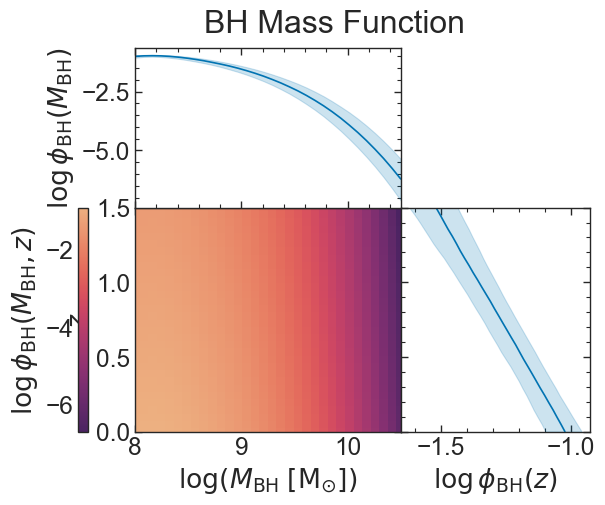

In [49]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_bhmf_combo_q[1], 
              log_bhmf_mbh_combo_combo_q, log_bhmf_z_combo_combo_q, ax, ax_xmarg, ax_ymarg)

# add the ruled out region
# ax.plot(log_m_max, z_cw_limit_range, 'k--')
# ax.fill_betweenx(z_cw_limit_range, log_m_max, 11, color='k', hatch='//', alpha=.4)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(0, 1.5)

ax_xmarg.set_ylabel(r'$\log \phi_{\rm BH}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 1)

# beta_eff = -.5
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 1.1
# ax_ymarg.plot(test_z_dep, z_range)

# beta_eff = -.75
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 1.1
# ax_ymarg.plot(test_z_dep, z_range)

# beta_eff = -1
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 1.1
# ax_ymarg.plot(test_z_dep, z_range)

# beta_eff = -1.2
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 1.1
# ax_ymarg.plot(test_z_dep, z_range)

ax_ymarg.set_xlabel(r'$\log \phi_{\rm BH}(z)$')
# ax_ymarg.set_xlim(-2.5, 1)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \phi_{\rm BH}(M_{\rm BH}, z)$')

fig.suptitle('BH Mass Function')

plt.show()

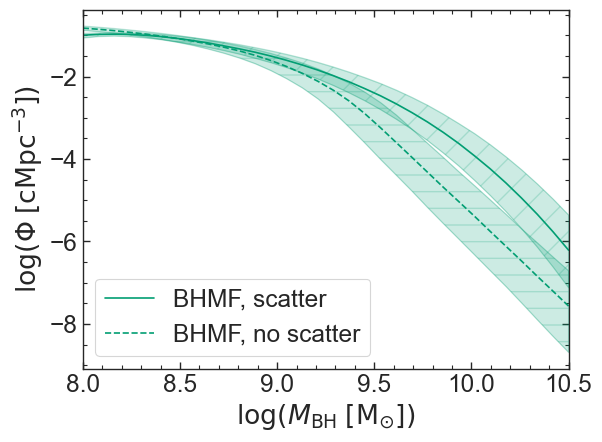

In [50]:
plt.figure()

plt.plot(log_mtot_range, log_bhmf_mbh_combo_combo_q[1], c=cs[2], ls='-', label=r'BHMF, scatter')
plt.fill_between(log_mtot_range, log_bhmf_mbh_combo_combo_q[0], log_bhmf_mbh_combo_combo_q[2], color=cs[2], alpha=.2)
plt.fill_between(log_mtot_range, log_bhmf_mbh_combo_combo_q[0], log_bhmf_mbh_combo_combo_q[2], facecolor='none', edgecolor=cs[2], alpha=.2, hatch='/')
plt.plot(log_mtot_range, log_bhmf_mbh_no_scatter_q[1], c=cs[2], ls='--', label=r'BHMF, no scatter')
plt.fill_between(log_mtot_range, log_bhmf_mbh_no_scatter_q[0], log_bhmf_mbh_no_scatter_q[2], color=cs[2], alpha=.2)
plt.fill_between(log_mtot_range, log_bhmf_mbh_no_scatter_q[0], log_bhmf_mbh_no_scatter_q[2], facecolor='none', edgecolor=cs[2], alpha=.2, hatch='-')

plt.xlim(LOG_M_MIN, LOG_M_MAX)
# plt.ylim(-12, -1)
plt.xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')
plt.legend()

plt.tight_layout()
plt.savefig('../reports/figures/bhmf_scatter_vs_no_scatter.pdf')
plt.show()

## BHBMF

In [51]:
mm_chirp = mm + .6 * np.log10(qq) - 1.2 * np.log10(1 + qq)
sample_points = np.array([mm_chirp, zz, qq])
sample_points = np.moveaxis(sample_points, 0, -1)
c19_sample_points = (log_m_chirp_c19, z_c19, q_bhb_c19)

In [52]:
def sample_bhbmf(bhbmf, samples_points_orig, sample_points_new, collapse_q=True):
    log_bhbmf = np.log10(bhbmf)

    log_bhbmf_samples = interpn(samples_points_orig,
                                log_bhbmf,
                                sample_points_new,
                                bounds_error=False, fill_value=None)
    
    bhbmf_samples = 10 ** log_bhbmf_samples
    # bhbmf_samples = np.moveaxis(bhbmf_samples, 0, -1)
    
    if collapse_q:
        # remove the q axis, noting that this has been integrated in bin
        bhbmf_samples = np.nansum(bhbmf_samples, axis=2)
    return bhbmf_samples

In [53]:
bhbmf_samples_combo_combo = sample_bhbmf(bhbmf_combo_combo, c19_sample_points, sample_points)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/3642705472.py:2: RuntimeWarning: divide by zero encountered in log10
  log_bhbmf = np.log10(bhbmf)


In [54]:
log_bhbmf_combo_combo = np.log10(bhbmf_samples_combo_combo)
log_bhbmf_combo_combo_q = np.quantile(log_bhbmf_combo_combo, q=QUANTILES, axis=-1)

In [55]:
# marginalize over redshift
log_bhbmf_mbh_combo_combo = np.log10(trapz(bhbmf_samples_combo_combo, z_range, axis=1))

# quantile
log_bhbmf_mbh_combo_combo_q = np.quantile(log_bhbmf_mbh_combo_combo, q=QUANTILES, axis=-1)

In [56]:
# marginalize over redshift
log_bhbmf_z_combo_combo = np.log10(trapz(bhbmf_samples_combo_combo, log_mtot_range, axis=0))

# quantile
log_bhbmf_z_combo_combo_q = np.quantile(log_bhbmf_z_combo_combo, q=QUANTILES, axis=-1)

In [57]:
# def plot_mass_function_quantiles(log_m_range, mass_function
def plot_mass_function(log_m_range, mass_function, quantiles, color=None, linestyle=None, alpha=.5, scale=.5, label=None):
    mf_q = np.quantile(mass_function, q=quantiles, axis=-1)
    
    n_quantiles = len(quantiles)
    n_plots = int(np.ceil(n_quantiles / 2))  # number of plotting calls
    
    # use plot for the middle index if odd, fill_between for the rest
    if n_quantiles % 2 == 1:
        middle_idx = int(np.ceil(n_quantiles / 2) - 1)
        plt.plot(log_m_range, mf_q[middle_idx], color=color, linestyle=linestyle, label=label)
        n_plots = n_plots - 1  # manually decrement the number of plots, 
                               # since this counts as one by above definition
            
    for i in range(n_plots):
        a = alpha * scale ** (n_plots - i - 1)
        plt.fill_between(log_m_range, mf_q[i], mf_q[-1-i], color=color, alpha=a)

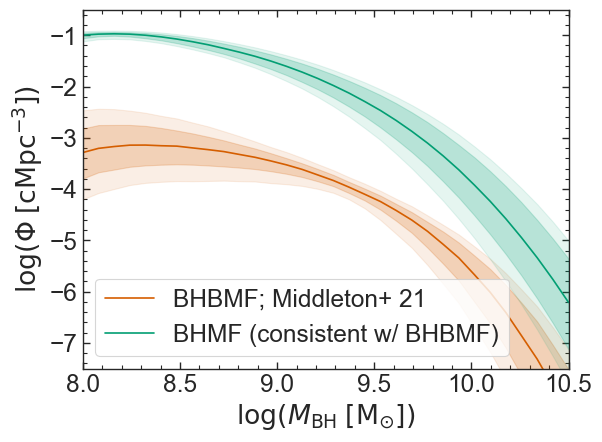

In [58]:
plt.figure()

quant = [.025, .16, .5, .84, .975]
plot_mass_function(
    log_mtot_range,
    log_bhbmf_mbh_combo_combo,
    quantiles=quant,
    color=cs[3],
    linestyle='-',
    alpha=.2,
    scale=.5,
    label=r'BHBMF; Middleton+ 21',
)
plot_mass_function(
    log_mtot_range,
    log_bhmf_mbh_combo_combo,
    quantiles=quant,
    color=cs[2],
    linestyle='-',
    alpha=.2,
    scale=.5,
    label=r'BHMF (consistent w/ BHBMF)',
)

plt.xlim(LOG_M_MIN, LOG_M_MAX)
plt.ylim(-7.5, -.5)
plt.xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')
plt.legend()

plt.tight_layout()
plt.savefig('../reports/figures/bhbmf_bhmf.pdf')
plt.show()

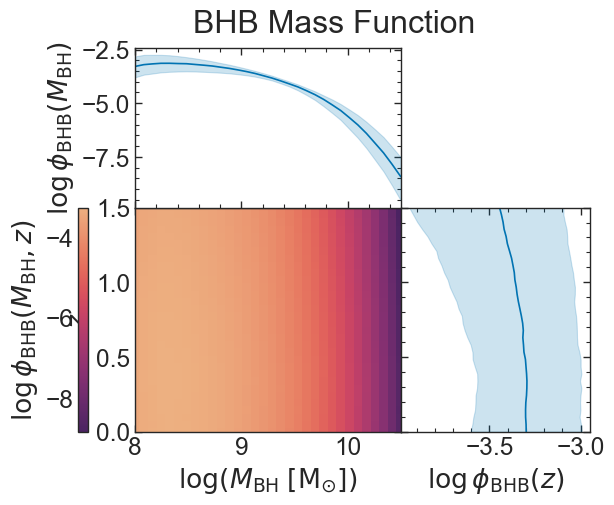

In [59]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_bhbmf_combo_combo_q[1], 
              log_bhbmf_mbh_combo_combo_q, log_bhbmf_z_combo_combo_q, ax, ax_xmarg, ax_ymarg)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(0, 1.5)

ax_xmarg.set_ylabel(r'$\log \phi_{\rm BHB}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 1)

# beta_eff = -.4
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 3.3
# ax_ymarg.plot(test_z_dep, z_range)

ax_ymarg.set_xlabel(r'$\log \phi_{\rm BHB}(z)$')
# ax_ymarg.set_xlim(-2.5, 1)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \phi_{\rm BHB}(M_{\rm BH}, z)$')

fig.suptitle('BHB Mass Function')

plt.show()

### Continuous Wave Limits

Let's apply limits from continuous wave (CW) searches, which look for GWs from individual SMBHBs. No CWs have been detected yet, but ...

We can apply limits from continuous waves to the SMBHB population by combining known PTA sensitivities with non-detections at this level. The GW signal emitted by a circular binary has strain

$$
h = \frac{2 (G \mathcal{M})^{5 / 3} (\pi f_{\rm gw})^{2 / 3}}{d_{\rm L} c^{4}} \\
$$
where $f_{\rm gw}$ is the observed frequency, $d_{\rm L}$ is the luminosity distance to the source, and $\mathcal{M}^{5 / 3} = [q / (1 + q)^{2}] M^{5 / 3}$ is the (observer frame) chirp mass of the binary.

In [60]:
G = const.G.to((u.Mpc ** 3) / (u.Msun * (u.s ** 2))).value
c = const.c.to(u.Mpc / u.s).value

In [61]:
def chirp_mass(m_tot, q):
    m_chirp = q / (1 + q ** 2)
    m_chirp = m_chirp ** (3 / 5)
    try:
        m_chirp = m_chirp * m_tot
    except Exception:
        m_chirp = m_chirp * m_tot[..., np.newaxis]
    return m_chirp


def log_chirp_mass(log_m_tot, q):
    m_tot = np.power(10, log_m_tot)
    m_chirp = chirp_mass(m_tot, q)
    log_m_chirp = np.log10(m_chirp)
    return log_m_chirp
    
    
def strain(log_m_tot, z, q, f_gw, cosmo=cosmo):
    consts = 2 * (G ** (5 / 3)) * (c ** -4) * (np.pi ** (2 / 3))
    
    m_tot = np.power(10, log_m_tot)
    m_chirp = chirp_mass(m_tot, q)
    m_term = m_chirp ** (5 / 3)
    
    f_term = f_gw ** (2 / 3)
    
    lum_dist = cosmo.luminosity_distance(z).to(u.Mpc).value
    
    h = consts * m_term * f_term / lum_dist
    
    return h

We can use this to check if our SMBHB population is consistent with continuous wave non-detections. We start by calculating $h(M, z, q, f_{\rm gw})$, the strain emitted by all possible sources in our parameter space. We'll also load the sensitivity curve, so we choose appropriate frequencies.

In [62]:
with open('../data/external/11yr_ul_skyavg.txt','rb') as fin:
    h_sens_ng11 = np.loadtxt(fin)
    
freqs_ng11 = h_sens_ng11[:, 0]
h_max_ng11 = h_sens_ng11[:, 1]

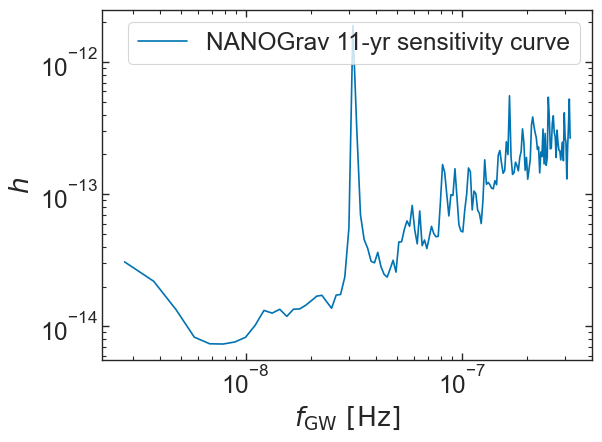

In [63]:
plt.figure()

plt.plot(freqs_ng11, h_max_ng11, label='NANOGrav 11-yr sensitivity curve', color=cs[0])

plt.xlabel(r'$f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$h$')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.tight_layout()

plt.savefig('../reports/figures/11-yr_sensitivity_curves.pdf')
plt.show()

In [64]:
log_mm_sens, zz_sens, qq_sens, ff_sens = np.meshgrid(log_mtot_range, z_range, q_range, freqs_ng11, indexing='ij')
h_bhbs = strain(log_mm_sens, zz_sens, qq_sens, ff_sens)  # divide by zero warning due to including z=0

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/1630941218.py:29: RuntimeWarning: divide by zero encountered in true_divide
  h = consts * m_term * f_term / lum_dist


Next we use the sky-averaged strain sensitivity, $h_{\rm CW}(f_{\rm GW})$ to determine all regions of $M-z-q-f_{\rm gw}$ parameter space that CW searches are sensitive to, such that $h(M, z, q, f_{\rm gw}) \geq h_{\rm CW}(f_{\rm gw})$.

In [65]:
visible_mask = h_bhbs >= h_max_ng11  # this works because of how our arrays align for broadcasting

To calculate the number of expected binaries in some region of parameter space we use a method based on Chen+ 2017, where we use the volume part of the number density to expand the differential number density of binaries in terms of their residence time at a given frequency. Functionally, we are just multiplying the proper-time binary formation rate by the frequency residence timescale
$$
\frac{d^{4} N_{\rm BHB}}{dM_{\rm BHB} dz dq df} = \frac{d^{4} N_{\rm BHB}}{dM_{\rm BHB} dz dq dV_{c}} \frac{dV_{c}}{dz} \frac{dz}{dt_{r}} \frac{dt_{r}}{df_{\rm r}} \frac{df_{r}}{df} = \frac{d^{3} \Phi_{\rm BHB}}{dM_{\rm BHB} dz dq} \frac{dV_{c}}{dz} \frac{dz}{dt_{r}} \frac{dt_{r}}{df_{\rm r}} \frac{df_{r}}{df}.
$$

In [66]:
def dtr_dz(z, cosmo=cosmo):
    denom = cosmo.H0.to(1 / u.s).value * (1 + z)
    denom = denom * np.sqrt((cosmo.Om0 * (1 + z) ** 3) 
                            + (cosmo.Ok0 * (1 + z) ** 2) 
                            + cosmo.Ode0)
    return 1 / denom


def dz_dtr(z, cosmo=cosmo):
    return 1 / dtr_dz(z, cosmo=cosmo)


def dfr_dtr(freq, log_m_chirp=None, log_mass=None, q=None):
    if log_m_chirp is None:
        if log_mass is None and q is None:
            raise ValueError("Must specify either chirp mass or mass and mass ratio.")
        else:
            log_m_chirp = log_chirp_mass(log_mass, q)
       
    try:
        res = (96 / 5) * (np.pi ** (8 / 3)) * (G ** (5 / 3)) / (c ** 5)
        res = res * 10 ** (5 * log_m_chirp / 3) 
        res = res * (freq ** (11 / 3))
    except:
        res = (96 / 5) * (np.pi ** (8 / 3)) * (G ** (5 / 3)) / (c ** 5)
        res = res * 10 ** (5 * log_m_chirp[..., np.newaxis] / 3) 
        res = res * (freq ** (11 / 3))
    
    return res


def dtr_dfr(freq, log_m_chirp=None, log_mass=None, q=None):
    if log_m_chirp is None:
        if log_mass is None and q is None:
            raise ValueError("Must specify either chirp mass or mass and mass ratio.")
        else:
            log_m_chirp = log_chirp_mass(log_mass, q)
    
    return 1 / dfr_dtr(freq, log_m_chirp=log_m_chirp)


def df_dfr(z):
    return 1 / (1 + z)


def dfr_df(z):
    return 1 + z


def dn_bhb(log_m, z, q, f_gw, bhb_samples):
    """Calculated the differential number of binaries overr mass, redshift, and frequency.
    
    Note that this is not the differential number density, but the actual differential number of BHBs.
    
    Parameters
    ----------
    bhb_samples : array_like of float
        The differential number density of BHBs as a function of redshift, 
        mass, and mass ratio (along each axis, respectively).
    z : array_like of float
        Sample redshifts, matched to `bhb_samples`.
    log_mass : array_like of float
        Base-10 logarithms of sample masses, matched to `bhb_samples`.
    q : array_like of float
        Sample mass ratios, matched to `bhb_samples`.
    freq : array_like of float
        Sample GW frequencies, matched to `bhb_samples`.
    
    """
    dVdz = cosmo.differential_comoving_volume(z).to(u.Mpc ** 3 / u.sr).value
    dVdz = 4 * np.pi * dVdz
    dVdz = dVdz[np.newaxis, :, np.newaxis, np.newaxis]
    
    dzdtr = dz_dtr(z, cosmo=cosmo)
    dzdtr = dzdtr[np.newaxis, :, np.newaxis, np.newaxis]
    
    dtrdfr = dtr_dfr(f_gw, log_mass=log_m, q=q)
    dtrdfr = dtrdfr[:, np.newaxis, ...]
    
    dfrdf = dfr_df(z)
    dfrdf = dfrdf[np.newaxis, :, np.newaxis, np.newaxis]

    try:
        res = dVdz * dzdtr * dtrdfr * dfrdf
        res = bhb_samples[..., np.newaxis] * res
    except:
        res = dVdz[..., np.newaxis] * dzdtr[..., np.newaxis] * dtrdfr[..., np.newaxis] * dfrdf[..., np.newaxis]
        res = bhb_samples[..., np.newaxis, :] * res
    
    return res

In [67]:
bhbmf_samples_mzq = sample_bhbmf(bhbmf_combo_combo, c19_sample_points, 
                                 sample_points, collapse_q=False)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/3642705472.py:2: RuntimeWarning: divide by zero encountered in log10
  log_bhbmf = np.log10(bhbmf)


We can also flip the strain equation to find the maximum visible distance as a function of total mass, 

$$
d_{\rm L}(M_{\rm BHB} | q, f_{\rm gw} h(f_{\rm gw})) = \frac{2 (G \mathcal{M})^{5 / 3} (\pi f_{\rm gw})^{2 / 3}}{c^{4} h(f_{\rm gw})} \\
\Rightarrow z(M_{\rm BHB} | q, f_{\rm gw} h(f_{\rm gw})) = d_{\rm L}^{-1}\left(\frac{2 (G \mathcal{M})^{5 / 3} (\pi f_{\rm gw})^{2 / 3}}{c^{4} h(f_{\rm gw})}\right)
$$

Let's plot the maximum visible redshift as a function of frequency for the 11-yr sensitivity curve. We'll then use this to choose a libearal and conservative frequency for ruling things out.

In [68]:
def binary_lum_dist(log_m_tot, q, f_gw, h):
    consts = 2 * (G ** (5 / 3)) * (c ** -4) * (np.pi ** (2 / 3))
    
    m_tot = np.power(10, log_m_tot)
    m_chirp = chirp_mass(m_tot, q)
    m_term = m_chirp ** (5 / 3)
    
    f_term = f_gw ** (2 / 3)
    
    lum_dist = (consts * m_term * f_term / h)  # [Mpc]
    return lum_dist


def z_max(log_m_tot, q, f_gw, h):
    lum_dist = binary_lum_dist(log_m_tot, q, f_gw, h) * u.Mpc
    z = z_at_value(cosmo.luminosity_distance, lum_dist).value
    return z


def binary_lum_dist_chirp(log_m_chirp, f_gw, h):
    consts = 2 * (G ** (5 / 3)) * (c ** -4) * (np.pi ** (2 / 3))
    
    m_chirp = np.power(10, log_m_chirp)
    m_term = m_chirp ** (5 / 3)
    
    f_term = f_gw ** (2 / 3)
    
    lum_dist = (consts * m_term * f_term / h)  # [Mpc]
    return lum_dist


def z_max_chirp(log_m_chirp, f_gw, h):
    lum_dist = binary_lum_dist_chirp(log_m_chirp, f_gw, h) * u.Mpc
    try:
        z = z_at_value(cosmo.luminosity_distance, lum_dist).value
    except Exception as e:
        print(lum_dist)
        raise e
    return z

In [69]:
# we'll choose fiducial mass and q values for now since we only need to be consistent
z_max_vs_f_ng11 = z_max(10, 1, freqs_ng11, h_max_ng11)

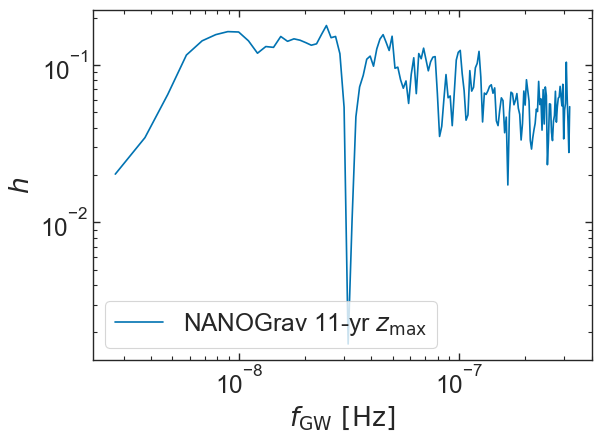

In [70]:
plt.figure()

plt.plot(freqs_ng11, z_max_vs_f_ng11, label=r'NANOGrav 11-yr $z_{\max}$', color=cs[0])

plt.xlabel(r'$f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$h$')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.tight_layout()

plt.savefig('../reports/figures/11-yr_max_redshift.pdf')
plt.show()

There's a massive spike in this data around $f = 1 / \rm{yr}$. Let's excise the spike and surrounding region before we determine our best and worst constraints.

In [71]:
diff = .25
f_cut_min = ((1 - diff) / u.yr).to(u.Hz)
f_cut_max = ((1 + diff) / u.yr).to(u.Hz)
f_cut_min, f_cut_max

(<Quantity 2.37660659e-08 Hz>, <Quantity 3.96101098e-08 Hz>)

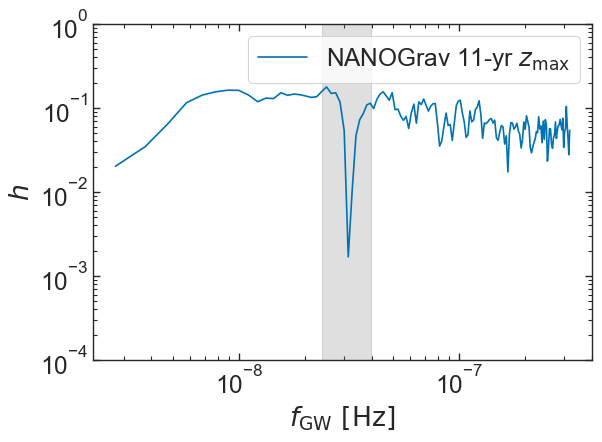

In [72]:
plt.figure()

plt.plot(freqs_ng11, z_max_vs_f_ng11, label=r'NANOGrav 11-yr $z_{\max}$', color=cs[0])
# plt.plot(freqs_ng12, z_max_vs_f_ng12, label=r'NANOGrav 12-yr $z_{\max}$', color=cs[1])

plt.fill_betweenx(np.linspace(0, 5), f_cut_min.value, f_cut_max.value, color='gray', alpha=.25)

plt.xlabel(r'$f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$h$')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-4, 1)

plt.legend()

plt.tight_layout()

plt.savefig('../reports/figures/11-yr_max_redshift_cut.pdf')
plt.show()

In [73]:
# remove the spike, then find our most and least sensitive frequencies
no_spike_mask = (freqs_ng11 <= f_cut_min.value) | (freqs_ng11 >= f_cut_max.value)  # cut out the spike at 1 / yr

freqs_ng11_no_spike = freqs_ng11[no_spike_mask]
h_max_ng11_no_spike = h_max_ng11[no_spike_mask]
z_max_vs_f_ng11_no_spike = z_max_vs_f_ng11[no_spike_mask]

conservative_limit_idx_ng11 = np.argmin(z_max_vs_f_ng11_no_spike)
liberal_limit_idx_ng11 = np.argmax(z_max_vs_f_ng11_no_spike)

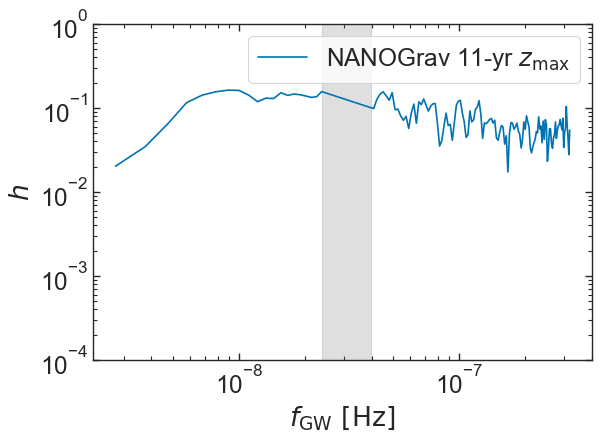

In [74]:
plt.figure()

plt.plot(freqs_ng11_no_spike, z_max_vs_f_ng11_no_spike, label=r'NANOGrav 11-yr $z_{\max}$', color=cs[0])
# plt.plot(freqs_ng12, z_max_vs_f_ng12, label=r'NANOGrav 12-yr $z_{\max}$', color=cs[1])

plt.fill_betweenx(np.linspace(0, 5), f_cut_min.value, f_cut_max.value, color='gray', alpha=.25)

plt.xlabel(r'$f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$h$')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-4, 1)

plt.legend()

plt.tight_layout()

plt.savefig('../reports/figures/11-yr_max_redshift_cut_no_spike.pdf')
plt.show()

In [75]:
log_m_cw_limit_range = np.linspace(LOG_M_MIN, LOG_M_MAX, 100)
f_fid_liberal = freqs_ng11_no_spike[liberal_limit_idx_ng11]
h_fid_liberal = h_max_ng11_no_spike[liberal_limit_idx_ng11]

z_max_liberal = z_max(log_m_cw_limit_range, .25, f_fid_liberal, h_fid_liberal)

In [76]:
z_max_liberal[-1]

0.45034669151471174

In [77]:
f_fid_conservative = freqs_ng11_no_spike[conservative_limit_idx_ng11]
h_fid_conservative = h_max_ng11_no_spike[conservative_limit_idx_ng11]

z_max_conservative = z_max(log_m_cw_limit_range, .25, f_fid_conservative, h_fid_conservative)

In [78]:
z_max_conservative[-1]

0.05390491838396936

In [79]:
from src.plot_utils import CurvedText

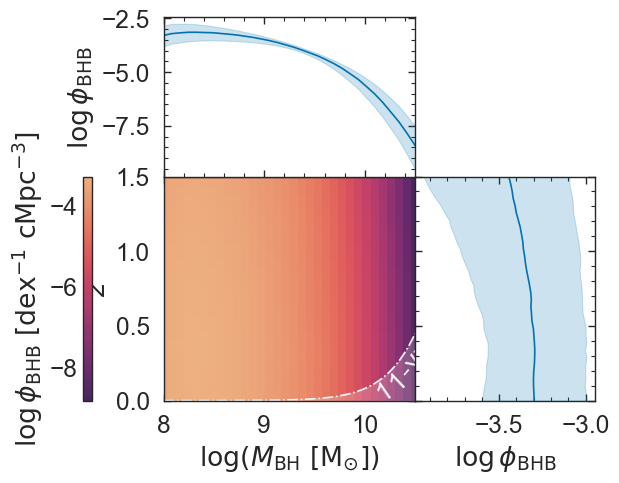

In [80]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 2, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)


# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_bhbmf_combo_combo_q[1], 
              log_bhbmf_mbh_combo_combo_q, log_bhbmf_z_combo_combo_q,
              ax, ax_xmarg, ax_ymarg, cmap='flare_r')

# add the visible/ruled out region
col_11 = 'whitesmoke'  # 'k'  # cs[0]
col_12 = 'white'  # cs[6]
z_max_ln = ax.plot(log_m_cw_limit_range, z_max_liberal, color=col_11, linestyle='-.', label='NG 11-yr max CW vis.')
ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal, facecolor=col_11, alpha=.2)
# ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal, facecolor='none', hatch='\\', edgecolor=col_11, alpha=.4)
lns = z_max_ln

n_skip = 78
text = CurvedText(
    x=log_m_cw_limit_range[n_skip:],
    y=z_max_liberal[n_skip:],
    text='11-yr',
    ha='right',
    va='top',
    axes=ax,
    color=col_11,
)

ax.set_xlabel(r'$\log (M_{\rm BH}~[{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.tick_params(axis='both', which='major', pad=10)

ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(Z_MIN, Z_MAX)

ax_xmarg.set_ylabel(r'$\log \phi_{\rm BHB}$')
# ax_xmarg.set_ylim(bottom=-0.5)
ax_xmarg.tick_params(axis='both', which='major', pad=10)

ax_ymarg.set_xlabel(r'$\log \phi_{\rm BHB}$')
# ax_ymarg.set_xlim(left=-.5)
ax_ymarg.tick_params(axis='both', which='major', pad=10)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \phi_{\rm BHB}~[\mathrm{dex^{-1}~cMpc^{-3}}]$')

labs = [l.get_label() for l in lns]

ax_empty = fig.add_subplot(gs[0, 3])
ax_empty.axis('off')

plt.savefig('../reports/figures/bhbs_vs_cws_ng11.pdf')
plt.savefig('../reports/figures/bhbs_vs_cws_ng11.png')

plt.show()

In [81]:
def dtr_dz(z, cosmo=cosmo):
    denom = cosmo.H0.to(1 / u.s).value * (1 + z)
    denom = denom * np.sqrt((cosmo.Om0 * (1 + z) ** 3) 
                            + (cosmo.Ok0 * (1 + z) ** 2) 
                            + cosmo.Ode0)
    return 1 / denom


def dz_dtr(z, cosmo=cosmo):
    return 1 / dtr_dz(z, cosmo=cosmo)


def dfr_dtr(freq, log_m_chirp=None, log_mass=None, q=None):
    if log_m_chirp is None:
        if log_mass is None and q is None:
            raise ValueError("Must specify either chirp mass or mass and mass ratio.")
        else:
            log_m_chirp = log_chirp_mass(log_mass, q)
       
    try:
        res = (96 / 5) * (np.pi ** (8 / 3)) * (G ** (5 / 3)) / (c ** 5)
        res = res * 10 ** (5 * log_m_chirp / 3) 
        res = res * (freq ** (11 / 3))
    except:
        res = (96 / 5) * (np.pi ** (8 / 3)) * (G ** (5 / 3)) / (c ** 5)
        res = res * 10 ** (5 * log_m_chirp[..., np.newaxis] / 3) 
        res = res * (freq ** (11 / 3))
    
    return res


def dtr_dfr(freq, log_m_chirp=None, log_mass=None, q=None):
    if log_m_chirp is None:
        if log_mass is None and q is None:
            raise ValueError("Must specify either chirp mass or mass and mass ratio.")
        else:
            log_m_chirp = log_chirp_mass(log_mass, q)
    
    return 1 / dfr_dtr(freq, log_m_chirp=log_m_chirp)


def df_dfr(z):
    return 1 / (1 + z)


def dfr_df(z):
    return 1 + z


def dn_bhb(log_m_chirp, z, f_gw, bhb_samples):
    """Calculated the differential number of binaries overr mass, redshift, and frequency.
    
    Note that this is not the differential number density, but the actual differential number of BHBs.
    
    Parameters
    ----------
    bhb_samples : array_like of float
        The differential number density of BHBs as a function of redshift, 
        mass, and mass ratio (along each axis, respectively).
    z : array_like of float
        Sample redshifts, matched to `bhb_samples`.
    log_mass : array_like of float
        Base-10 logarithms of sample masses, matched to `bhb_samples`.
    q : array_like of float
        Sample mass ratios, matched to `bhb_samples`.
    freq : array_like of float
        Sample GW frequencies, matched to `bhb_samples`.
    
    """
    dVdz = cosmo.differential_comoving_volume(z).to(u.Mpc ** 3 / u.sr).value
    dVdz = 4 * np.pi * dVdz
    dVdz = dVdz[np.newaxis, :, np.newaxis]
    
    dzdtr = dz_dtr(z, cosmo=cosmo)
    dzdtr = dzdtr[np.newaxis, :, np.newaxis]
    
    dtrdfr = dtr_dfr(f_gw, log_m_chirp=log_m_chirp)
    dtrdfr = dtrdfr[:, np.newaxis, ...]
    
    dfrdf = dfr_df(z)
    dfrdf = dfrdf[np.newaxis, :, np.newaxis]

    try:
        res = dVdz * dzdtr * dtrdfr * dfrdf
        res = bhb_samples[..., np.newaxis] * res
    except:
        res = dVdz[..., np.newaxis] * dzdtr[..., np.newaxis] * dtrdfr[..., np.newaxis] * dfrdf[..., np.newaxis]
        res = bhb_samples[..., np.newaxis, :] * res
    
    return res

## QMF

In [82]:
ll, mm, zz = np.meshgrid(log_lbol_range, log_mtot_range, z_range, indexing='ij')

In [83]:
# Manual calculation of the probability.
# Like Marconi et al. (2004), we assume log normal
loc = ll[..., np.newaxis] - ler.log_lbol_to_log_edd(ll, scatter=0) - qb.LOG_EDD_SCALE  # converts from Lbol to the Mbh centroid
prob = norm.pdf(mm[..., np.newaxis], loc=loc, scale=ler.scatter)

# sample the qlf
log_qlf_samples = qlf(ll, zz)

# convolve
qmf_samples = np.power(10, log_qlf_samples - np.log10(1 - ler.slope))[:, 0, ...]

In [84]:
# Manual calculation of the probability.
# Like Marconi et al. (2004), we assume log normal
loc = ll[..., np.newaxis] - ler.log_lbol_to_log_edd(ll, scatter=0) - qb.LOG_EDD_SCALE  # converts from Lbol to the Mbh centroid
prob = norm.pdf(mm[..., np.newaxis], loc=loc, scale=ler.scatter)
prob_half_scatter = norm.pdf(mm[..., np.newaxis], loc=loc, scale=ler.scatter/2)

# sample the qlf
log_qlf_samples = qlf(ll, zz) + np.log10(.38) # estimate of the type-1 qso fraction (Shen+ 2020)

# convolve
qmf_samples = trapz(np.power(10, np.log10(prob) + log_qlf_samples), log_lbol_range, axis=0)
qmf_samples_half_scatter = trapz(np.power(10, np.log10(prob_half_scatter) + log_qlf_samples), log_lbol_range, axis=0)
qmf_samples_no_scatter = np.power(10, log_qlf_samples - np.log10(1 - ler.slope))[:, 0, ...]

In [85]:
log_mbh_no_scatter = ler.log_lbol_to_log_mbh(log_lbol_range, scatter=0)
log_mbh_no_scatter_q = np.quantile(log_mbh_no_scatter, q=.5, axis=-1)

In [86]:
log_qmf = np.log10(qmf_samples)
log_qmf_q = np.quantile(log_qmf, q=QUANTILES, axis=-1)

In [87]:
log_qmf_half_scatter = np.log10(qmf_samples_half_scatter)
log_qmf_half_scatter_q = np.quantile(log_qmf_half_scatter, q=QUANTILES, axis=-1)

In [88]:
log_qmf_no_scatter = np.log10(qmf_samples_no_scatter)
log_qmf_no_scatter_q = np.quantile(log_qmf_no_scatter, q=QUANTILES, axis=-1)

In [89]:
# marginalize over redshift
log_qmf_mbh = np.log10(trapz(qmf_samples, z_range, axis=1))

# quantile
log_qmf_mbh_q = np.quantile(log_qmf_mbh, q=QUANTILES, axis=-1)

In [90]:
# marginalize over redshift
log_qmf_z = np.log10(trapz(qmf_samples, log_mtot_range, axis=0))

# quantile
log_qmf_z_q = np.quantile(log_qmf_z, q=QUANTILES, axis=-1)

In [91]:
# marginalize over redshift
log_qmf_mbh_half_scatter = np.log10(trapz(qmf_samples_half_scatter, z_range, axis=1))

# quantile
log_qmf_mbh_half_scatter_q = np.quantile(log_qmf_mbh_half_scatter, q=QUANTILES, axis=-1)

In [92]:
# marginalize over redshift
log_qmf_mbh_no_scatter = np.log10(trapz(qmf_samples_no_scatter, z_range, axis=1))

# quantile
log_qmf_mbh_no_scatter_q = np.quantile(log_qmf_mbh_no_scatter, q=QUANTILES, axis=-1)

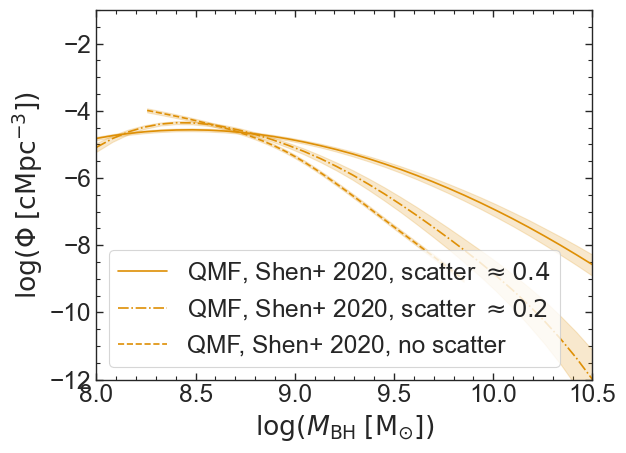

In [93]:
plt.figure()

plt.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF, Shen+ 2020, scatter $\approx 0.4$')
plt.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)
plt.plot(log_mtot_range, log_qmf_mbh_half_scatter_q[1], c=cs[1], ls='-.', label=r'QMF, Shen+ 2020, scatter $\approx 0.2$')
plt.fill_between(log_mtot_range, log_qmf_mbh_half_scatter_q[0], log_qmf_mbh_half_scatter_q[2], color=cs[1], alpha=.2)
plt.plot(log_mbh_no_scatter_q, log_qmf_mbh_no_scatter_q[1], c=cs[1], ls='--', label=r'QMF, Shen+ 2020, no scatter')
plt.fill_between(log_mbh_no_scatter_q, log_qmf_mbh_no_scatter_q[0], log_qmf_mbh_no_scatter_q[2], color=cs[1], alpha=.2)

plt.xlim(LOG_M_MIN, LOG_M_MAX)
plt.ylim(-12, -1)
plt.xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')
plt.legend()
            
plt.show()

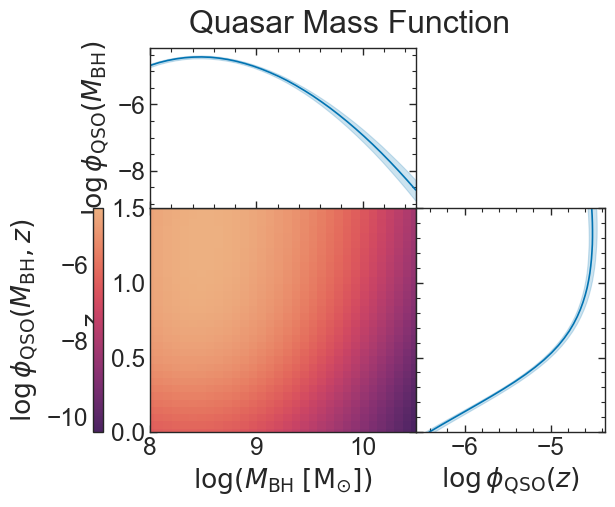

In [94]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_qmf_q[1], 
              log_qmf_mbh_q, log_qmf_z_q, ax, ax_xmarg, ax_ymarg)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(0, 1.5)

ax_xmarg.set_ylabel(r'$\log \phi_{\rm QSO}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 1)

ax_ymarg.set_xlabel(r'$\log \phi_{\rm QSO}(z)$')
# ax_ymarg.set_xlim(-2.5, 1)

# beta_eff = 4.9
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 6.45
# ax_ymarg.plot(test_z_dep, z_range)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \phi_{\rm QSO}(M_{\rm BH}, z)$')

fig.suptitle('Quasar Mass Function')

plt.show()

## Binary quasar mass function

In [95]:
# sample the qlf
# if SCHECHTER:
log_bqlf_samples = np.log10(crts_qlf(log_lbol_range, z_range))  # crts_qlf(ll, zz)
log_bqlf_samples = np.moveaxis(log_bqlf_samples, 0, -1)  # move monte carlo axis to match others

In [96]:
# sample the qlf
# if SCHECHTER:
ll_check, zz_check = np.meshgrid(log_lbol_range, z_range, indexing='ij')
log_qlf_samples_check = qlf(ll_check, zz_check) + np.log10(.38)  # crts_qlf(ll, zz)

# log_qlf_samples_check = np.moveaxis(log_bqlf_samples, 0, -1)  # move monte carlo axis to match others

In [97]:
# marginalize over redshift
log_bqlf_lbol = np.log10(trapz(np.power(10, log_bqlf_samples), z_range, axis=1))

# quantile
log_bqlf_lbol_q = np.quantile(log_bqlf_lbol, q=QUANTILES, axis=-1)

In [98]:
# marginalize over redshift
log_qlf_lbol = np.log10(trapz(np.power(10, log_qlf_samples_check), z_range, axis=1))

# quantile
log_qlf_lbol_q = np.quantile(log_qlf_lbol, q=QUANTILES, axis=-1)

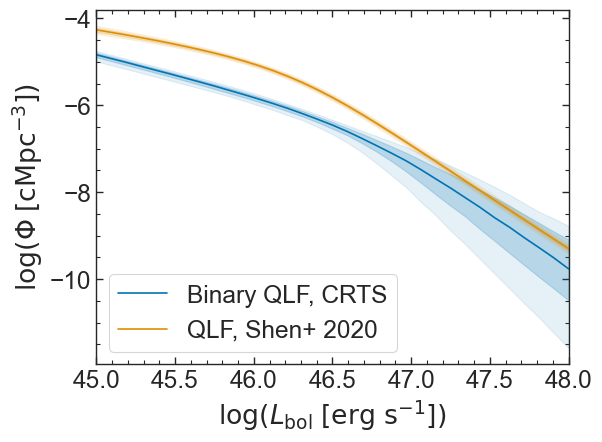

In [99]:
plt.figure()

# plt.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'Binary QMF, CRTS')
# plt.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)

# plt.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF, Shen+ 2020')
# plt.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)

plot_mass_function(
    log_lbol_range,
    log_bqlf_lbol,
    quantiles=quant,
    color=cs[0],
    linestyle='-',
    alpha=.2,
    scale=.5,
    label=r'Binary QLF, CRTS',
)
plot_mass_function(
    log_lbol_range,
    log_qlf_lbol,
    quantiles=quant,
    color=cs[1],
    linestyle='-',
    alpha=.2,
    scale=.5,
    label=r'QLF, Shen+ 2020',
)

plt.xlim(LOG_LBOL_MIN, LOG_LBOL_MAX)
# plt.ylim(-7.5, -.5)
plt.xlabel(r'$\log (L_{\rm bol} \; [{\rm erg~s^{-1}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')

plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/bq_lum_function.pdf')
            
plt.show()

In [100]:
# convolve
log_bqlf_samples = log_bqlf_samples[:, np.newaxis, ...]
bqmf_samples = trapz(np.power(10, np.log10(prob) + log_bqlf_samples), log_lbol_range, axis=0)
bqmf_samples_half_scatter = trapz(np.power(10, np.log10(prob_half_scatter) + log_bqlf_samples), log_lbol_range, axis=0)
bqmf_samples_no_scatter = np.power(10, log_bqlf_samples - np.log10(1 - ler.slope))[:, 0, ...]

In [101]:
log_bqmf = np.log10(bqmf_samples)
log_bqmf_q = np.quantile(log_bqmf, q=QUANTILES, axis=-1)

In [102]:
log_bqmf_half_scatter = np.log10(bqmf_samples_half_scatter)
log_bqmf_half_scatter_q = np.quantile(log_bqmf_half_scatter, q=QUANTILES, axis=-1)

In [103]:
log_bqmf_no_scatter = np.log10(bqmf_samples_no_scatter)
log_bqmf_no_scatter_q = np.quantile(log_bqmf_no_scatter, q=QUANTILES, axis=-1)

In [104]:
# marginalize over redshift
log_bqmf_mbh = np.log10(trapz(bqmf_samples, z_range, axis=1))

# quantile
log_bqmf_mbh_q = np.quantile(log_bqmf_mbh, q=QUANTILES, axis=-1)

In [105]:
# marginalize over redshift
log_bqmf_z = np.log10(trapz(bqmf_samples, log_mtot_range, axis=0))

# quantile
log_bqmf_z_q = np.quantile(log_bqmf_z, q=QUANTILES, axis=-1)

In [106]:
# marginalize over redshift
log_bqmf_mbh_half_scatter = np.log10(trapz(bqmf_samples_half_scatter, z_range, axis=1))

# quantile
log_bqmf_mbh_half_scatter_q = np.quantile(log_bqmf_mbh_half_scatter, q=QUANTILES, axis=-1)

In [107]:
# marginalize over redshift
log_bqmf_mbh_no_scatter = np.log10(trapz(bqmf_samples_no_scatter, z_range, axis=1))

# quantile
log_bqmf_mbh_no_scatter_q = np.quantile(log_bqmf_mbh_no_scatter, q=QUANTILES, axis=-1)

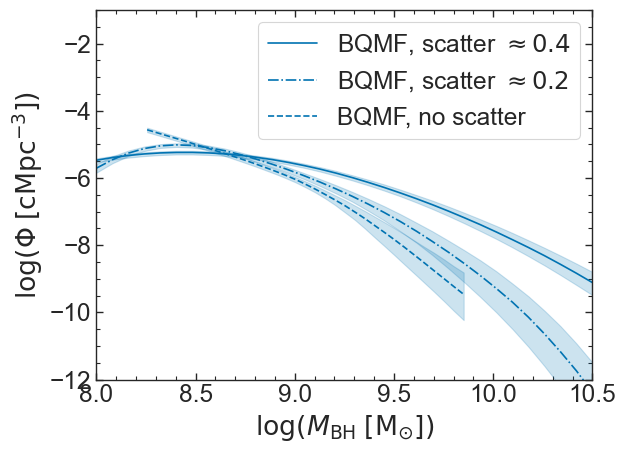

In [108]:
plt.figure()

plt.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'BQMF, scatter $\approx 0.4$')
plt.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)
plt.plot(log_mtot_range, log_bqmf_mbh_half_scatter_q[1], c=cs[0], ls='-.', label=r'BQMF, scatter $\approx 0.2$')
plt.fill_between(log_mtot_range, log_bqmf_mbh_half_scatter_q[0], log_bqmf_mbh_half_scatter_q[2], color=cs[0], alpha=.2)
plt.plot(log_mbh_no_scatter_q, log_bqmf_mbh_no_scatter_q[1], c=cs[0], ls='--', label=r'BQMF, no scatter')
plt.fill_between(log_mbh_no_scatter_q, log_bqmf_mbh_no_scatter_q[0], log_bqmf_mbh_no_scatter_q[2], color=cs[0], alpha=.2)

plt.xlim(LOG_M_MIN, LOG_M_MAX)
plt.ylim(-12, -1)
plt.xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')
plt.legend()
            
plt.show()

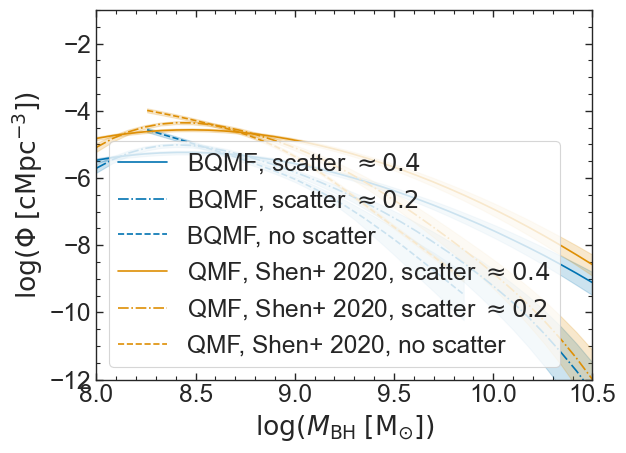

In [109]:
plt.figure()

plt.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'BQMF, scatter $\approx 0.4$')
plt.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)
plt.plot(log_mtot_range, log_bqmf_mbh_half_scatter_q[1], c=cs[0], ls='-.', label=r'BQMF, scatter $\approx 0.2$')
plt.fill_between(log_mtot_range, log_bqmf_mbh_half_scatter_q[0], log_bqmf_mbh_half_scatter_q[2], color=cs[0], alpha=.2)
plt.plot(log_mbh_no_scatter_q, log_bqmf_mbh_no_scatter_q[1], c=cs[0], ls='--', label=r'BQMF, no scatter')
plt.fill_between(log_mbh_no_scatter_q, log_bqmf_mbh_no_scatter_q[0], log_bqmf_mbh_no_scatter_q[2], color=cs[0], alpha=.2)

plt.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF, Shen+ 2020, scatter $\approx 0.4$')
plt.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)
plt.plot(log_mtot_range, log_qmf_mbh_half_scatter_q[1], c=cs[1], ls='-.', label=r'QMF, Shen+ 2020, scatter $\approx 0.2$')
plt.fill_between(log_mtot_range, log_qmf_mbh_half_scatter_q[0], log_qmf_mbh_half_scatter_q[2], color=cs[1], alpha=.2)
plt.plot(log_mbh_no_scatter_q, log_qmf_mbh_no_scatter_q[1], c=cs[1], ls='--', label=r'QMF, Shen+ 2020, no scatter')
plt.fill_between(log_mbh_no_scatter_q, log_qmf_mbh_no_scatter_q[0], log_qmf_mbh_no_scatter_q[2], color=cs[1], alpha=.2)

plt.xlim(LOG_M_MIN, LOG_M_MAX)
plt.ylim(-12, -1)
plt.xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')
plt.legend()
            
plt.show()

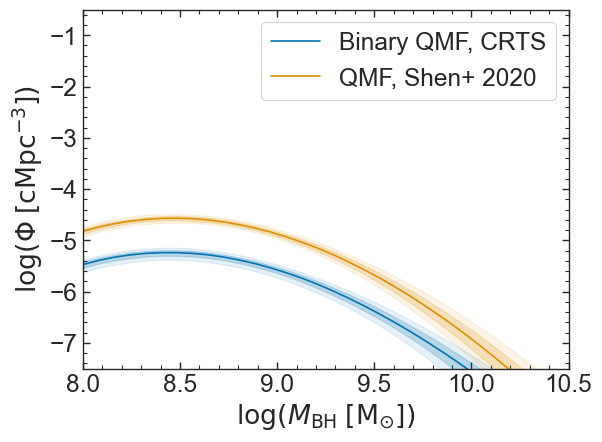

In [110]:
plt.figure()

# plt.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'Binary QMF, CRTS')
# plt.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)

# plt.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF, Shen+ 2020')
# plt.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)

plot_mass_function(
    log_mtot_range,
    log_bqmf_mbh,
    quantiles=quant,
    color=cs[0],
    linestyle='-',
    alpha=.2,
    scale=.5,
    label=r'Binary QMF, CRTS',
)
plot_mass_function(
    log_mtot_range,
    log_qmf_mbh,
    quantiles=quant,
    color=cs[1],
    linestyle='-',
    alpha=.2,
    scale=.5,
    label=r'QMF, Shen+ 2020',
)

plt.xlim(LOG_M_MIN, LOG_M_MAX)
plt.ylim(-7.5, -.5)
plt.xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
plt.ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')

plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/bq_mass_function.pdf')
            
plt.show()

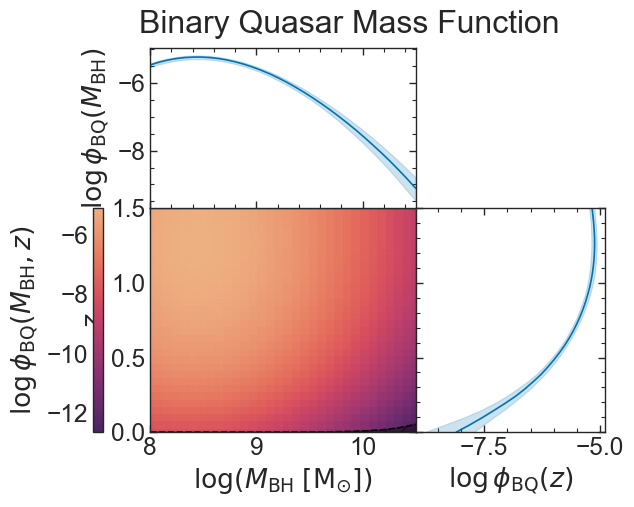

In [111]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_bqmf_q[1], 
              log_bqmf_mbh_q, log_bqmf_z_q, ax, ax_xmarg, ax_ymarg)

# add the ruled out region
ax.plot(log_m_cw_limit_range, z_max_conservative, 'k--')
ax.fill_between(log_m_cw_limit_range, 0, z_max_conservative, color='k', hatch='//', alpha=.4)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(0, 1.5)

ax_xmarg.set_ylabel(r'$\log \phi_{\rm BQ}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 1)

ax_ymarg.set_xlabel(r'$\log \phi_{\rm BQ}(z)$')
# ax_ymarg.set_xlim(-2.5, 1)

# beta_eff = 4.9
# test_z_dep = np.log10(((1 + z_range) ** beta_eff)) - 6.45
# ax_ymarg.plot(test_z_dep, z_range)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \phi_{\rm BQ}(M_{\rm BH}, z)$')

fig.suptitle('Binary Quasar Mass Function')

plt.show()

# Occupation Fractions

In [112]:
def total_occupation_frac(main_pop_mf, sub_pop_mf, log_m_range, z_range):
    log_main_pop = np.log10(trapz(trapz(main_pop_mf, z_range, axis=1), log_m_range, axis=0))
    log_sub_pop = np.log10(trapz(trapz(sub_pop_mf, z_range, axis=1), log_m_range, axis=0))
    
    return 10 ** (log_sub_pop - log_main_pop)


def mass_occupation_frac(main_pop_mf, sub_pop_mf, z_range):
    log_main_pop = np.log10(trapz(main_pop_mf, z_range, axis=1))
    log_sub_pop = np.log10(trapz(sub_pop_mf, z_range, axis=1))
    
    return 10 ** (log_sub_pop - log_main_pop)

def z_occupation_frac(main_pop_mf, sub_pop_mf, log_m_range):
    log_main_pop = np.log10(trapz(main_pop_mf, log_m_range, axis=0))
    log_sub_pop = np.log10(trapz(sub_pop_mf, log_m_range, axis=0))
    
    return 10 ** (log_sub_pop - log_main_pop)


def occupation_frac(main_pop_mf, sub_pop_mf):
    log_main_pop = np.log10(main_pop_mf)
    log_sub_pop = np.log10(sub_pop_mf)
    
    return 10 ** (log_sub_pop - log_main_pop)

## Binary Occupation Fraction

### Combined GSMF

#### Combined McConnell & Ma 13 + Kormendy & Ho 2013

In [113]:
# then calculate the mean binary occupation fraction
f_bhb_mean_combo_combo = total_occupation_frac(bhmf_samples_combo_combo,
                                               bhbmf_samples_combo_combo,
                                               log_mtot_range, z_range)
f_bhb_mean_combo_combo_q = np.quantile(f_bhb_mean_combo_combo, q=QUANTILES)
f_bhb_mean_combo_combo_err = np.diff(f_bhb_mean_combo_combo_q)
display(Math(r'\bar{{\mathcal{{F}}}}_{{\rm BHB}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'
             .format(f_bhb_mean_combo_combo_q[1], f_bhb_mean_combo_combo_err[0],
                     f_bhb_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

We can similarly calculate the binary occupation fraction as a function of mass
$$
\bar{\mathcal{F}}_{\rm BHB}(M_{\rm BH}) = \frac{\iint \phi_{\rm BHB}(M_{\rm BH}, z, q) dz dq}{\iint \phi_{\rm G}(M_{\rm BH}, z, q) dz dq},
$$

In [114]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_bhb_mbh_combo_combo = mass_occupation_frac(bhmf_samples_combo_combo,
                                             bhbmf_samples_combo_combo,
                                             z_range)
log_f_bhb_mbh_combo_combo = np.log10(f_bhb_mbh_combo_combo)

log_f_bhb_mbh_combo_combo_q = np.quantile(log_f_bhb_mbh_combo_combo, q=QUANTILES, axis=-1)
f_bhb_mbh_combo_combo_q = 10 ** log_f_bhb_mbh_combo_combo_q

redshift,
$$
\bar{\mathcal{F}}_{\rm BHB}(z) = \frac{\int \phi_{\rm BHB}(M_{\rm BH}, z) dM_{\rm BH}}{\int \phi_{\rm G}(M_{\rm BH}, z) dM_{\rm BH}},
$$

In [115]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_bhb_z_combo_combo = z_occupation_frac(bhmf_samples_combo_combo,
                                        bhbmf_samples_combo_combo,
                                        log_mtot_range)
log_f_bhb_z_combo_combo = np.log10(f_bhb_z_combo_combo)

log_f_bhb_z_combo_combo_q = np.quantile(log_f_bhb_z_combo_combo, q=QUANTILES, axis=-1)
f_bhb_z_combo_combo_q = 10 ** log_f_bhb_z_combo_combo_q

or mass and redshift
$$
\mathcal{F}_{\rm BHB}(M_{\rm BH}, z) = \frac{\phi_{\rm BHB}(M_{\rm BH}, z)}{\phi_{\rm G}(M_{\rm BH}, z)}.
$$

In [116]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_bhb_combo_combo = occupation_frac(bhmf_samples_combo_combo,
                                    bhbmf_samples_combo_combo)
log_f_bhb_combo_combo = np.log10(f_bhb_combo_combo)

log_f_bhb_combo_combo_q = np.quantile(log_f_bhb_combo_combo, q=QUANTILES, axis=-1)
f_bhb_combo_combo_q = 10 ** log_f_bhb_combo_combo_q

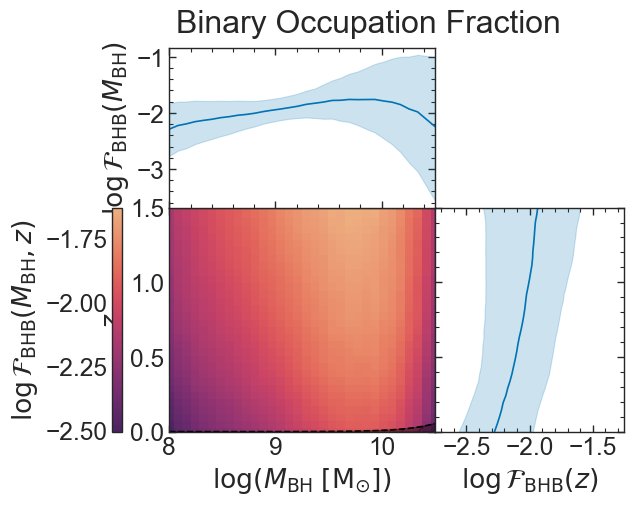

In [117]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_f_bhb_combo_combo_q[1], 
              log_f_bhb_mbh_combo_combo_q, log_f_bhb_z_combo_combo_q, ax, ax_xmarg, ax_ymarg)

# add the ruled out region
ax.plot(log_m_cw_limit_range, z_max_conservative, 'k--')
ax.fill_between(log_m_cw_limit_range, 0, z_max_conservative, color='k', hatch='//', alpha=.4)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(0, 1.5)

ax_xmarg.set_ylabel(r'$\log \mathcal{F}_{\rm BHB}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 1)

ax_ymarg.set_xlabel(r'$\log \mathcal{F}_{\rm BHB}(z)$')
ax_ymarg.set_xlim(-2.75, -1.25)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \mathcal{F}_{\rm BHB}(M_{\rm BH}, z)$')

fig.suptitle('Binary Occupation Fraction')

plt.savefig('../reports/figures/f_bhb.pdf')

plt.show()

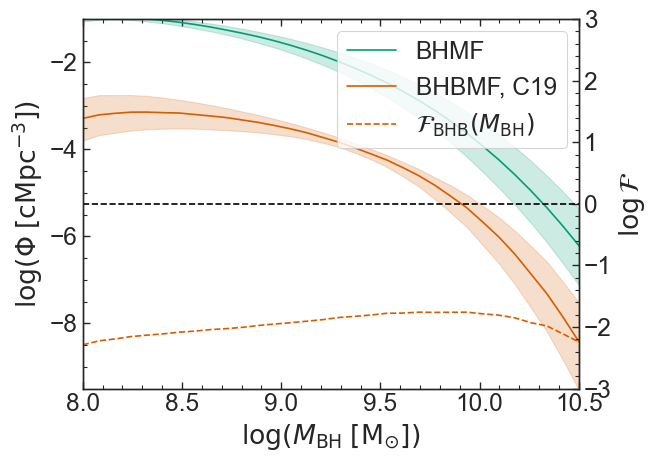

In [118]:
fig, ax1 = plt.subplots()

# bqmf_ln = ax1.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'Binary QMF, CRTS')
# ax1.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)

# qmf_ln = ax1.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF, S20')
# ax1.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)

bhmf_ln = ax1.plot(log_mtot_range, log_bhmf_mbh_combo_combo_q[1], c=cs[2], ls='-', label=r'BHMF')
ax1.fill_between(log_mtot_range, log_bhmf_mbh_combo_combo_q[0], log_bhmf_mbh_combo_combo_q[2], color=cs[2], alpha=.2)

bhbmf_ln = ax1.plot(log_mtot_range, log_bhbmf_mbh_combo_combo_q[1], c=cs[3], ls='-', label=r'BHBMF, C19')
ax1.fill_between(log_mtot_range, log_bhbmf_mbh_combo_combo_q[0], log_bhbmf_mbh_combo_combo_q[2], color=cs[3], alpha=.2)

ax1.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax1.set_ylim(-9.5, -1)
ax1.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax1.set_ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')

ax2 = ax1.twinx()

ax2.axhline(0, color='k', linestyle='--')

# f_bhb_qso_ln = ax2.plot(log_mtot_range, log_f_bhb_qso_mbh_combo_combo_q[1], c=cs[0], 
#                         ls='--', label=r'$\mathcal{F}_{\rm BHB | QSO}(M_{\rm BH})$')
f_bhb_ln = ax2.plot(log_mtot_range, log_f_bhb_mbh_combo_combo_q[1], c=cs[3], 
                    ls='--', label=r'$\mathcal{F}_{\rm BHB}(M_{\rm BH})$')

ax2.set_ylim(-3, 3)
ax2.set_ylabel(r'$\log \mathcal{F}$')

# combine legends
lns = bhmf_ln + bhbmf_ln + f_bhb_ln
# lns = bhbmf_ln + gmf_ln + f_bhb
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

# plt.title(r'Combined $M_{\rm BH} - M_{\rm bulge}$')

plt.savefig(r'../reports/figures/bhb_occ_frac.pdf')

plt.show()

## Quasar Occupation Fraction

In [119]:
# then calculate the mean binary occupation fraction
f_qso_mean_combo_combo = total_occupation_frac(bhmf_samples_combo_combo,
                                               qmf_samples,
                                               log_mtot_range, z_range)
f_qso_mean_combo_combo_q = np.quantile(f_qso_mean_combo_combo, q=QUANTILES)
f_qso_mean_combo_combo_err = np.diff(f_qso_mean_combo_combo_q)
display(Math(r'\bar{{\mathcal{{F}}}}_{{\rm QSO}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'
             .format(f_qso_mean_combo_combo_q[1], f_qso_mean_combo_combo_err[0],
                     f_qso_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

In [120]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_qso_mbh_combo_combo = mass_occupation_frac(bhmf_samples_combo_combo,
                                             qmf_samples,
                                             z_range)
log_f_qso_mbh_combo_combo = np.log10(f_qso_mbh_combo_combo)

log_f_qso_mbh_combo_combo_q = np.quantile(log_f_qso_mbh_combo_combo, q=QUANTILES, axis=-1)
f_qso_mbh_combo_combo_q = 10 ** log_f_qso_mbh_combo_combo_q

In [121]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_qso_z_combo_combo = z_occupation_frac(bhmf_samples_combo_combo,
                                        qmf_samples,
                                        log_mtot_range)
log_f_qso_z_combo_combo = np.log10(f_qso_z_combo_combo)

log_f_qso_z_combo_combo_q = np.quantile(log_f_qso_z_combo_combo, q=QUANTILES, axis=-1)
f_qso_z_combo_combo_q = 10 ** log_f_qso_z_combo_combo_q

In [122]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_qso_combo_combo = occupation_frac(bhmf_samples_combo_combo,
                                    qmf_samples)
log_f_qso_combo_combo = np.log10(f_qso_combo_combo)

log_f_qso_combo_combo_q = np.quantile(log_f_qso_combo_combo, q=QUANTILES, axis=-1)
f_qso_combo_combo_q = 10 ** log_f_qso_combo_combo_q

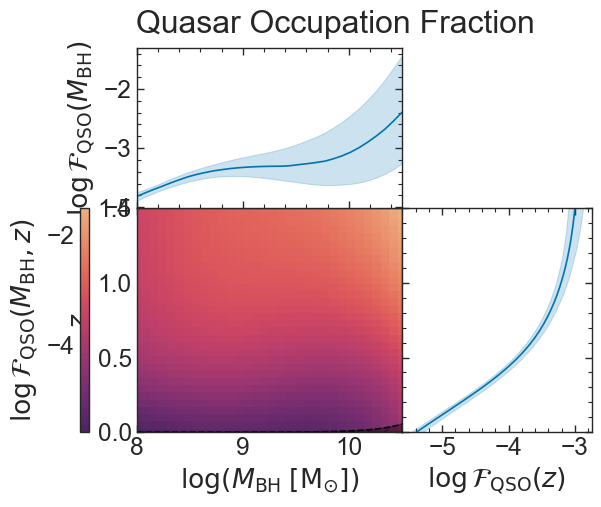

In [123]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_f_qso_combo_combo_q[1], 
              log_f_qso_mbh_combo_combo_q, log_f_qso_z_combo_combo_q, ax, ax_xmarg, ax_ymarg)

# add the ruled out region
ax.plot(log_m_cw_limit_range, z_max_conservative, 'k--')
ax.fill_between(log_m_cw_limit_range, 0, z_max_conservative, color='k', hatch='//', alpha=.4)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(0, 1.5)

ax_xmarg.set_ylabel(r'$\log \mathcal{F}_{\rm QSO}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 1)

ax_ymarg.set_xlabel(r'$\log \mathcal{F}_{\rm QSO}(z)$')
# ax_ymarg.set_xlim(-2.5, 1)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \mathcal{F}_{\rm QSO}(M_{\rm BH}, z)$')

fig.suptitle('Quasar Occupation Fraction')

plt.show()

## Binary Occupation Fraction of Quasars

In [124]:
# then calculate the mean binary occupation fraction
f_bhb_qso_mean_combo_combo = total_occupation_frac(qmf_samples,
                                                   bqmf_samples,
                                                   log_mtot_range, z_range)
f_bhb_qso_mean_combo_combo_q = np.quantile(f_bhb_qso_mean_combo_combo, q=QUANTILES)
f_bhb_qso_mean_combo_combo_err = np.diff(f_bhb_qso_mean_combo_combo_q)
display(Math(r'\bar{{\mathcal{{F}}}}_{{\rm BHB | QSO}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'
             .format(f_bhb_qso_mean_combo_combo_q[1], f_bhb_qso_mean_combo_combo_err[0],
                     f_bhb_qso_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

In [125]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_bhb_qso_mbh_combo_combo = mass_occupation_frac(qmf_samples,
                                                 bqmf_samples,
                                                 z_range)
log_f_bhb_qso_mbh_combo_combo = np.log10(f_bhb_qso_mbh_combo_combo)

log_f_bhb_qso_mbh_combo_combo_q = np.quantile(log_f_bhb_qso_mbh_combo_combo, q=QUANTILES, axis=-1)
f_bhb_qso_mbh_combo_combo_q = 10 ** log_f_bhb_qso_mbh_combo_combo_q

In [126]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_bhb_qso_z_combo_combo = z_occupation_frac(qmf_samples,
                                        bqmf_samples,
                                        log_mtot_range)
log_f_bhb_qso_z_combo_combo = np.log10(f_bhb_qso_z_combo_combo)

log_f_bhb_qso_z_combo_combo_q = np.quantile(log_f_bhb_qso_z_combo_combo, q=QUANTILES, axis=-1)
f_bhb_qso_z_combo_combo_q = 10 ** log_f_bhb_qso_z_combo_combo_q

In [127]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_bhb_qso_combo_combo = occupation_frac(qmf_samples,
                                        bqmf_samples)
log_f_bhb_qso_combo_combo = np.log10(f_bhb_qso_combo_combo)

log_f_bhb_qso_combo_combo_q = np.quantile(log_f_bhb_qso_combo_combo, q=QUANTILES, axis=-1)
f_bhb_qso_combo_combo_q = 10 ** log_f_bhb_qso_combo_combo_q

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/3591755522.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


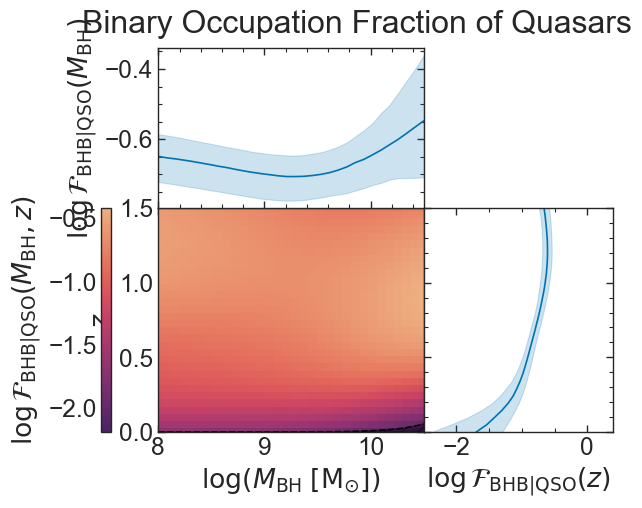

In [128]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_f_bhb_qso_combo_combo_q[1], 
              log_f_bhb_qso_mbh_combo_combo_q, log_f_bhb_qso_z_combo_combo_q, ax, ax_xmarg, ax_ymarg)

# add the ruled out region
ax.plot(log_m_cw_limit_range, z_max_conservative, 'k--')
ax.fill_between(log_m_cw_limit_range, 0, z_max_conservative, color='k', hatch='//', alpha=.4)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(Z_MIN, Z_MAX)

ax_xmarg.set_ylabel(r'$\log \mathcal{F}_{\rm BHB | QSO}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 0.75)

ax_ymarg.set_xlabel(r'$\log \mathcal{F}_{\rm BHB | QSO}(z)$')
ax_ymarg.set_xlim(-2.5, .4)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \mathcal{F}_{\rm BHB | QSO}(M_{\rm BH}, z)$')

fig.suptitle('Binary Occupation Fraction of Quasars')

plt.tight_layout()

plt.savefig('../reports/figures/f_bhb_qso.pdf')

plt.show()

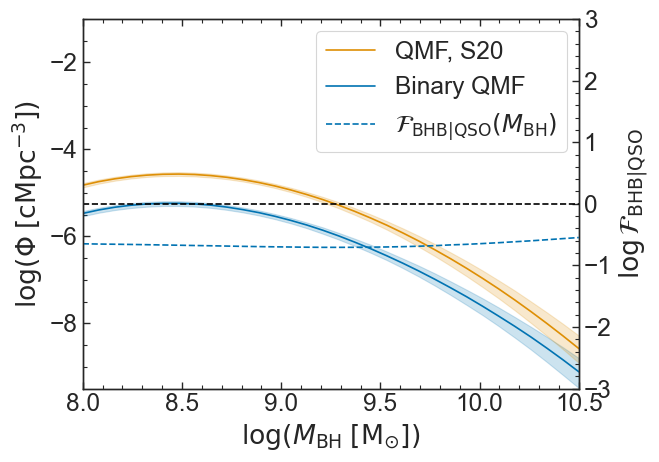

In [129]:
fig, ax1 = plt.subplots()

bqmf_ln = ax1.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'Binary QMF')
ax1.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)

qmf_ln = ax1.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF, S20')
ax1.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)

ax1.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax1.set_ylim(-9.5, -1)
ax1.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax1.set_ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')

ax2 = ax1.twinx()

ax2.axhline(0, color='k', linestyle='--')

f_bhb_qso_ln = ax2.plot(log_mtot_range, log_f_bhb_qso_mbh_combo_combo_q[1], c=cs[0], 
                        ls='--', label=r'$\mathcal{F}_{\rm BHB | QSO}(M_{\rm BH})$')

ax2.set_ylim(-3, 3)
ax2.set_ylabel(r'$\log \mathcal{F}_{\rm BHB | QSO}$')

# combine legends
lns = qmf_ln + bqmf_ln + f_bhb_qso_ln
# lns = bhbmf_ln + gmf_ln + f_bhb
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plt.savefig('../reports/figures/bq_sch_sty_ext_reduced_qso_mass_functions_frac.pdf')
            
plt.show()

## Quasar Occupation Fraction of Binaries

In [130]:
# then calculate the mean binary occupation fraction
f_qso_bhb_mean_combo_combo = total_occupation_frac(bhbmf_samples_combo_combo,
                                                   bqmf_samples,
                                                   log_mtot_range, z_range)
f_qso_bhb_mean_combo_combo_q = np.quantile(f_qso_bhb_mean_combo_combo, q=QUANTILES)
f_qso_bhb_mean_combo_combo_err = np.diff(f_qso_bhb_mean_combo_combo_q)
display(Math(r'\bar{{\mathcal{{F}}}}_{{\rm QSO | BHB}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'
             .format(f_qso_bhb_mean_combo_combo_q[1], f_qso_bhb_mean_combo_combo_err[0],
                     f_qso_bhb_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

In [131]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_qso_bhb_mbh_combo_combo = mass_occupation_frac(bhbmf_samples_combo_combo,
                                             bqmf_samples,
                                             z_range)
log_f_qso_bhb_mbh_combo_combo = np.log10(f_qso_bhb_mbh_combo_combo)

log_f_qso_bhb_mbh_combo_combo_q = np.quantile(log_f_qso_bhb_mbh_combo_combo, q=QUANTILES, axis=-1)
f_qso_bhb_mbh_combo_combo_q = 10 ** log_f_qso_bhb_mbh_combo_combo_q

In [132]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_qso_bhb_z_combo_combo = z_occupation_frac(bhbmf_samples_combo_combo,
                                        bqmf_samples,
                                        log_mtot_range)
log_f_qso_bhb_z_combo_combo = np.log10(f_qso_bhb_z_combo_combo)

log_f_qso_bhb_z_combo_combo_q = np.quantile(log_f_qso_bhb_z_combo_combo, q=QUANTILES, axis=-1)
f_qso_bhb_z_combo_combo_q = 10 ** log_f_qso_bhb_z_combo_combo_q

In [133]:
# then calculate the binary occupation fraction over mass
# we already calculated the total mass function earlier, so we can skip it now
f_qso_bhb_combo_combo = occupation_frac(bhbmf_samples_combo_combo,
                                    bqmf_samples)
log_f_qso_bhb_combo_combo = np.log10(f_qso_bhb_combo_combo)

log_f_qso_bhb_combo_combo_q = np.quantile(log_f_qso_bhb_combo_combo, q=QUANTILES, axis=-1)
f_qso_bhb_combo_combo_q = 10 ** log_f_qso_bhb_combo_combo_q

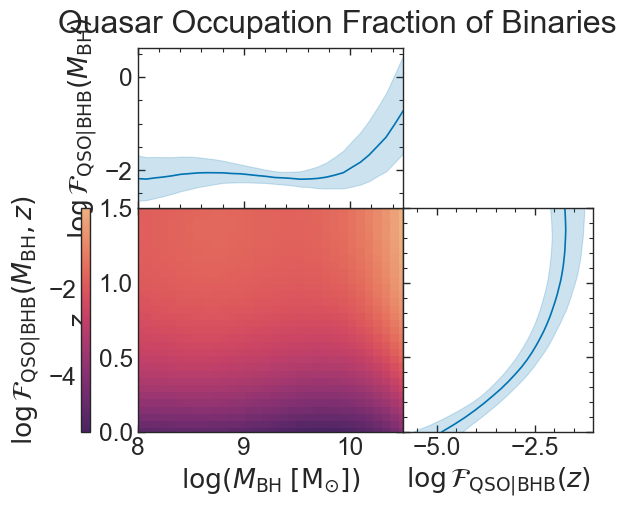

In [134]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# use the previously defined function
pcm = heatmap(log_mtot_range, z_range, log_f_qso_bhb_combo_combo_q[1], 
              log_f_qso_bhb_mbh_combo_combo_q, log_f_qso_bhb_z_combo_combo_q, ax, ax_xmarg, ax_ymarg)

# add the ruled out region
# ax.plot(log_m_cw_limit_range, z_max_conservative, 'k--')
# ax.fill_between(log_m_cw_limit_range, 0, z_max_conservative, color='k', hatch='//', alpha=.4)

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(Z_MIN, Z_MAX)

ax_xmarg.set_ylabel(r'$\log \mathcal{F}_{\rm QSO | BHB}(M_{\rm BH})$')
# ax_xmarg.set_ylim(-2.5, 0.75)

ax_ymarg.set_xlabel(r'$\log \mathcal{F}_{\rm QSO | BHB}(z)$')
# ax_ymarg.set_xlim(-2.5, .4)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log \mathcal{F}_{\rm QSO | BHB}(M_{\rm BH}, z)$')

fig.suptitle('Quasar Occupation Fraction of Binaries')

plt.savefig('../reports/figures/f_qso_bhb.pdf')

plt.show()

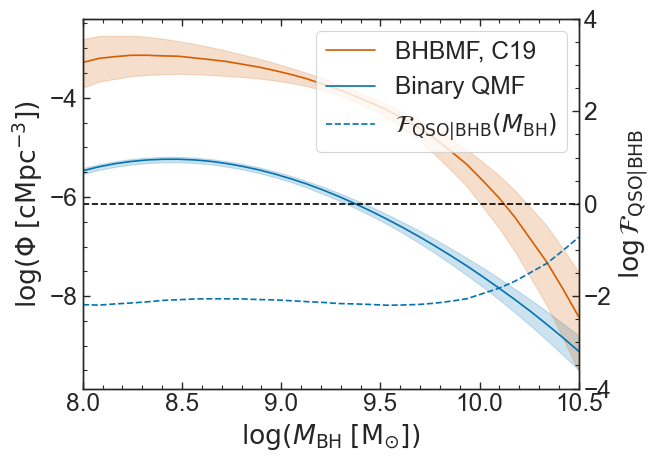

In [135]:
fig, ax1 = plt.subplots()

bqmf_ln = ax1.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'Binary QMF')
ax1.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)

qmf_ln = ax1.plot(log_mtot_range, log_bhbmf_mbh_combo_combo_q[1], c=cs[3], ls='-', label=r'BHBMF, C19')
ax1.fill_between(log_mtot_range, log_bhbmf_mbh_combo_combo_q[0], log_bhbmf_mbh_combo_combo_q[2], color=cs[3], alpha=.2)

ax1.set_xlim(LOG_M_MIN, LOG_M_MAX)
# ax1.set_ylim(-9.5, -.5)
ax1.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax1.set_ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')

ax2 = ax1.twinx()

ax2.axhline(0, color='k', linestyle='--')

f_qso_bhb_ln = ax2.plot(log_mtot_range, log_f_qso_bhb_mbh_combo_combo_q[1], c=cs[0], 
                        ls='--', label=r'$\mathcal{F}_{\rm QSO | BHB}(M_{\rm BH})$')

ax2.set_ylim(-4, 4)
ax2.set_ylabel(r'$\log \mathcal{F}_{\rm QSO | BHB}$')

# combine legends
lns = qmf_ln + bqmf_ln + f_qso_bhb_ln
# lns = bhbmf_ln + gmf_ln + f_bhb
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plt.savefig('../reports/figures/bq_bhb_mass_functions_frac.pdf')
            
plt.show()

# Occupation Fraction Comparison

## Binary Occupation Fraction of Quasars vs. Binary Occupation Fraction

In [136]:
# QUANTILES = [.025, .5, .975]

In [137]:
# then calculate the mean binary occupation fraction of quasars
f_bhb_qso_mean_vs_f_bhb_mean_combo_combo = f_bhb_qso_mean_combo_combo / f_bhb_mean_combo_combo
f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_q = np.quantile(f_bhb_qso_mean_vs_f_bhb_mean_combo_combo, q=QUANTILES)
f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_err = np.diff(f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_q)
display(Math(r'\frac{{\bar{{\mathcal{{F}}}}_{{\rm BHB | QSO}}}}{{\bar{{\mathcal{{F}}}}_{{\rm BHB}}}} '
             r'= {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'.format(f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_q[1],
                                                           f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_err[0],
                                                           f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

In [138]:
# then calculate the binary occupation fraction over mass
f_bhb_qso_vs_bhb_mbh_combo_combo = f_bhb_qso_mbh_combo_combo / f_bhb_mbh_combo_combo
f_bhb_qso_vs_bhb_mbh_combo_combo_q = np.quantile(f_bhb_qso_vs_bhb_mbh_combo_combo, q=QUANTILES, axis=-1)

# then calculate the binary occupation fraction over mass
f_bhb_qso_vs_bhb_z_combo_combo = f_bhb_qso_z_combo_combo / f_bhb_z_combo_combo
f_bhb_qso_vs_bhb_z_combo_combo_q = np.quantile(f_bhb_qso_vs_bhb_z_combo_combo, q=QUANTILES, axis=-1)

# calculate the BQ occupation fraction over mass
f_bhb_qso_vs_f_bhb_combo_combo = f_bhb_qso_combo_combo / f_bhb_combo_combo
f_bhb_qso_vs_f_bhb_combo_combo_q = np.quantile(f_bhb_qso_vs_f_bhb_combo_combo, q=QUANTILES, axis=-1)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/2136024940.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


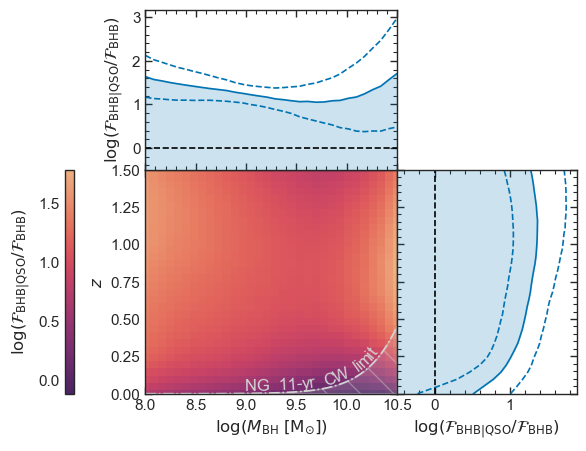

In [139]:
# start with a square Figure
sns.set_context(context, font_scale=1.25)
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 2, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# vmax = np.maximum(np.abs(np.min(np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1]))),
#                   np.abs(np.max(np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1]))))
# vmin = - vmax

log_f_ratio = np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1])
log_f_ratio_log_mbh = np.log10(f_bhb_qso_vs_bhb_mbh_combo_combo_q)
log_f_ratio_z = np.log10(f_bhb_qso_vs_bhb_z_combo_combo_q)
# use the previously defined function
pcm = heatmap(
    log_mtot_range, 
    z_range, 
    log_f_ratio, 
    log_f_ratio_log_mbh, 
    log_f_ratio_z,
    ax, 
    ax_xmarg, 
    ax_ymarg,
    cmap='flare_r',
    dashed=True
    # vmin=1, 
    # vmax=2
)

# ax.contour(log_mtot_range, z_range, np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1]).T, colors='k', levels=[0.])

# add the visible/ruled out region
col_11 = 'lightgray'  # 'k'  #cs[6]
col_12 = cs[0]
z_max_ln = ax.plot(
    log_m_cw_limit_range, 
    z_max_liberal, 
    color=col_11, 
    linestyle='-.', 
    # label='NG 11-yr max CW vis.',
)
ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal, facecolor=col_11, alpha=.2)
ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal, facecolor='none', hatch='\\', edgecolor=col_11, alpha=.4)
lns = z_max_ln

n_skip = 35
text = CurvedText(
    x=log_m_cw_limit_range[n_skip:],
    y=z_max_liberal[n_skip:],
    text='NG 11-yr CW limit',
    ha='right',
    va='bottom',
    axes=ax,
    color=col_11,
)

ax_xmarg.axhline(0, color='k', linestyle='--')

ax_ymarg.axvline(0, color='k', linestyle='--')

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')
ax.tick_params(
    axis='both', 
    which='major', 
    # pad=5
)

ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(Z_MIN, Z_MAX)

ax_xmarg.set_ylabel(r'$\log(\mathcal{F}_{\rm BHB|QSO} / \mathcal{F}_{\rm BHB})$')
ax_xmarg.set_ylim(bottom=-.5)
ax_xmarg.tick_params(
    axis='both', 
    which='major', 
    # pad=5
)

ax_ymarg.set_xlabel(r'$\log(\mathcal{F}_{\rm BHB|QSO} / \mathcal{F}_{\rm BHB})$')
ax_ymarg.set_xlim(left=-.5)
ax_ymarg.tick_params(
    axis='both', 
    which='major', 
    # pad=5
)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log(\mathcal{F}_{\rm BHB|QSO} / \mathcal{F}_{\rm BHB})$')

labs = [l.get_label() for l in lns]

ax_empty = fig.add_subplot(gs[0, 3])
ax_empty.axis('off')
# ax_empty.legend(lns, labs, loc='upper left', frameon=False)

# fig.suptitle(r'$\mathcal{F}_{\rm BHB|QSO}$ vs. $\mathcal{F}_{\rm BHB}$')
plt.tight_layout()
plt.savefig('../reports/figures/f_bhb_qso_vs_f_bhb.pdf')
plt.savefig('../reports/figures/f_bhb_qso_vs_f_bhb.png')
plt.show()

In [140]:
from scipy.integrate import trapezoid as trapz

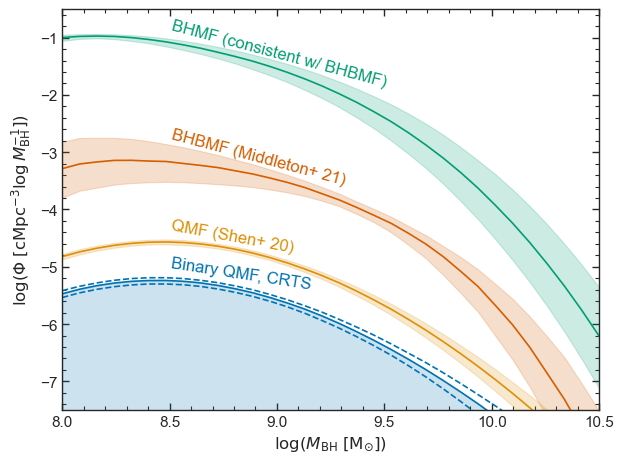

In [141]:
fig, ax1 = plt.subplots()

bhbmf_ln = ax1.plot(log_mtot_range, log_bhbmf_mbh_combo_combo_q[1], c=cs[3], ls='-', label=r'BHBMF; Middleton+ 21')
ax1.fill_between(log_mtot_range, log_bhbmf_mbh_combo_combo_q[0], log_bhbmf_mbh_combo_combo_q[2], color=cs[3], alpha=.2)
ax1.text(
    8.5,
    -3 + .2,
    r'BHBMF (Middleton+ 21)',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='left',
    va='bottom',
    transform_rotates_text=True, 
    rotation=-45,
    rotation_mode='anchor',
    color=cs[3]
)

bhmf_ln = ax1.plot(log_mtot_range, log_bhmf_mbh_combo_combo_q[1], c=cs[2], ls='-', label=r'BHMF (consistent w/ BHBMF)')
ax1.fill_between(log_mtot_range, log_bhmf_mbh_combo_combo_q[0], log_bhmf_mbh_combo_combo_q[2], color=cs[2], alpha=.2)
ax1.text(
    8.5,
    -1 + .1,
    r'BHMF (consistent w/ BHBMF)',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='left',
    va='bottom',
    transform_rotates_text=True, 
    rotation=-45,
    rotation_mode='anchor',
    color=cs[2]
)

qmf_ln = ax1.plot(log_mtot_range, log_qmf_mbh_q[1], c=cs[1], ls='-', label=r'QMF; Shen+ 20')
ax1.fill_between(log_mtot_range, log_qmf_mbh_q[0], log_qmf_mbh_q[2], color=cs[1], alpha=.2)
ax1.text(
    8.5,
    -4.5 + .1,
    r'QMF (Shen+ 20)',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='left',
    va='bottom',
    transform_rotates_text=True, 
    rotation=-35,
    rotation_mode='anchor',
    color=cs[1]
)

bqmf_ln = ax1.plot(log_mtot_range, log_bqmf_mbh_q[1], c=cs[0], ls='-', label=r'Binary QMF, CRTS')
ax1.plot(log_mtot_range, log_bqmf_mbh_q[0], c=cs[0], ls='--')
ax1.plot(log_mtot_range, log_bqmf_mbh_q[2], c=cs[0], ls='--')
# ax1.fill_between(log_mtot_range, log_bqmf_mbh_q[0], log_bqmf_mbh_q[2], color=cs[0], alpha=.2)
# n_arrow = 4
# for lm, lf in zip(log_mtot_range[::n_arrow], log_bqmf_mbh_q[1][::n_arrow]):
#     # print(lm)
#     # print(lf)
#     ax1.arrow(lm, lf, 0, -.75,
#               color=cs[0], 
#               # linestyle=':', 
#               width=.001, 
#               head_width=.02,
#               # alpha=.2
#              )
ax1.fill_between(
    log_mtot_range, 
    -10, 
    log_bqmf_mbh_q[1],
    color=cs[0],
    # facecolor='none',
    # hatch='/', 
    # edgecolor=cs[0], 
    alpha=.2
)
    
ax1.text(
    8.5,
    -5.05,
    r'Binary QMF, CRTS',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='left',
    va='bottom',
    transform_rotates_text=True, 
    rotation=-30,
    rotation_mode='anchor',
    color=cs[0]
)

ax1.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax1.set_ylim(-7.5, -.5)
ax1.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax1.set_ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}} \log M_{\rm BH}^{-1}])$')

plt.tight_layout()
plt.savefig('../reports/figures/mass_functions.pdf') 
plt.savefig('../reports/figures/mass_functions.png') 
plt.show()

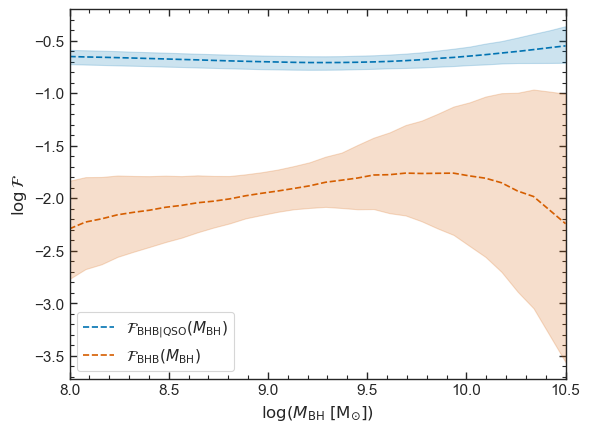

In [142]:
fig, ax1 = plt.subplots()

f_bhb_qso_ln = ax1.plot(log_mtot_range, log_f_bhb_qso_mbh_combo_combo_q[1], c=cs[0], 
                        ls='--', label=r'$\mathcal{F}_{\rm BHB | QSO}(M_{\rm BH})$')
ax1.fill_between(log_mtot_range, log_f_bhb_qso_mbh_combo_combo_q[0], log_f_bhb_qso_mbh_combo_combo_q[2], color=cs[0], alpha=.2)
f_bhb_ln = ax1.plot(log_mtot_range, log_f_bhb_mbh_combo_combo_q[1], c=cs[3], 
                    ls='--', label=r'$\mathcal{F}_{\rm BHB}(M_{\rm BH})$')
ax1.fill_between(log_mtot_range, log_f_bhb_mbh_combo_combo_q[0], log_f_bhb_mbh_combo_combo_q[2], color=cs[3], alpha=.2)

# ax1.set_ylim(-3, 3)
ax1.set_ylabel(r'$\log \mathcal{F}$')

ax1.set_xlim(LOG_M_MIN, LOG_M_MAX)
# ax1.set_ylim(-12, 0)
ax1.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
# ax1.set_ylabel(r'$\log (\Phi \; [{\rm cMpc^{-3}}])$')

plt.legend()

# plt.title(r'Combined $M_{\rm BH} - M_{\rm bulge}$')

plt.savefig(r'../reports/figures/occupation_fractions.pdf')

plt.show()

### Comparison to Kelley et al. (2019)

In [143]:
crts_pop = pd.read_csv('../data/processed/reduced_crts_complete.csv')
prec = np.sum(crts_pop['weight']) / len(crts_pop)
prec_kelley = 5 / 111
n_max_kelley = prec_kelley * len(crts_pop)

scale = prec_kelley / prec

In [144]:
display(Math(r'\bar{{\mathcal{{F}}}}_{{\rm BHB | QSO}} = {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'
             .format(scale * f_bhb_qso_mean_combo_combo_q[1], scale * f_bhb_qso_mean_combo_combo_err[0],
                     scale * f_bhb_qso_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

In [145]:
display(Math(r'\frac{{\bar{{\mathcal{{F}}}}_{{\rm BHB | QSO}}}}{{\bar{{\mathcal{{F}}}}_{{\rm BHB}}}} '
             r'= {0:.4f}_{{-{1:.4f}}}^{{+{2:.4f}}}'.format(scale * f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_q[1],
                                                           scale * f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_err[0],
                                                           scale * f_bhb_qso_mean_vs_f_bhb_mean_combo_combo_err[1])))

<IPython.core.display.Math object>

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/2304879982.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


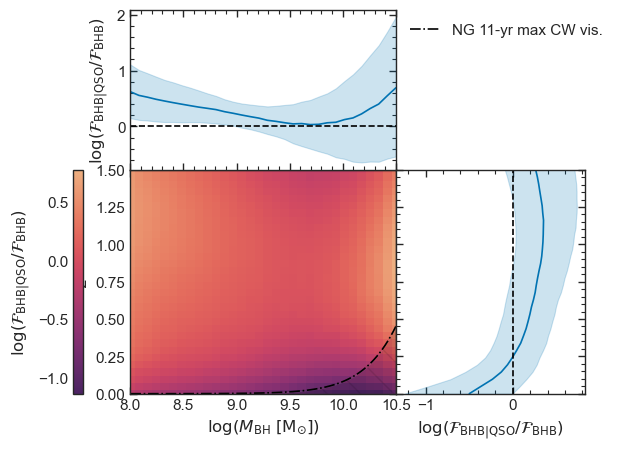

In [146]:
# start with a square Figure
fig = plt.figure()

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(.25, 1.25, 7, 5), height_ratios=(5, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 2])
ax_xmarg = fig.add_subplot(gs[0, 2], sharex=ax)
ax_ymarg = fig.add_subplot(gs[1, 3], sharey=ax)

# vmax = np.maximum(np.abs(np.min(np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1]))),
#                   np.abs(np.max(np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1]))))
# vmin = - vmax

# use the previously defined function
log_f_ratio = np.log10(scale * f_bhb_qso_vs_f_bhb_combo_combo_q[1])
log_f_ratio_log_mbh = np.log10(scale * f_bhb_qso_vs_bhb_mbh_combo_combo_q)
log_f_ratio_z = np.log10(scale * f_bhb_qso_vs_bhb_z_combo_combo_q)
# use the previously defined function
pcm = heatmap(
    log_mtot_range, 
    z_range, 
    log_f_ratio, 
    log_f_ratio_log_mbh, 
    log_f_ratio_z,
    ax, 
    ax_xmarg, 
    ax_ymarg,
    # vmin=1, 
    # vmax=2
)

# ax.contour(log_mtot_range, z_range, np.log10(f_bhb_qso_vs_f_bhb_combo_combo_q[1]).T, colors='k', levels=[0.])

# add the ruled out region
z_max_ln = ax.plot(log_m_cw_limit_range, z_max_liberal, 'k-.', label='NG 11-yr max CW vis.')
ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal, facecolor='k', alpha=.1)
ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal, facecolor='none', hatch='\\', edgecolor='k', alpha=.1)
lns = z_max_ln

# z_max_ln_ng12 = ax.plot(log_m_cw_limit_range, z_max_liberal_ng12, 'b--', label='NG 12.5-yr max CW vis.')
# ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal_ng12, facecolor='b', alpha=.1)
# ax.fill_between(log_m_cw_limit_range, 0, z_max_liberal_ng12, facecolor='none', hatch='//', edgecolor='b', alpha=.1)
# lns = lns + z_max_ln_ng12

# z_ruled_out_ln = ax.plot(log_m_cw_limit_range, z_max_conservative, 'g--', label='NG 11-yr nondetection')
# ax.fill_between(log_m_cw_limit_range, 0, z_max_conservative, color='g', hatch='//', alpha=.1)
# lns = lns + z_ruled_out_ln

ax_xmarg.axhline(0, color='k', linestyle='--')
ax_ymarg.axvline(0, color='k', linestyle='--')

ax.set_xlabel(r'$\log (M_{\rm BH} \; [{\rm M_{\odot}}])$')
ax.set_ylabel(r'$z$')

ax.set_xlim(LOG_M_MIN, LOG_M_MAX)
ax.set_ylim(Z_MIN, Z_MAX)

ax_xmarg.set_ylabel(r'$\log(\mathcal{F}_{\rm BHB|QSO} / \mathcal{F}_{\rm BHB})$')
# ax_xmarg.set_ylim(-.25, 1.75)

ax_ymarg.set_xlabel(r'$\log(\mathcal{F}_{\rm BHB|QSO} / \mathcal{F}_{\rm BHB})$')
# ax_ymarg.set_xlim(left=-.5)

# add a colorbar
ax_cb = fig.add_subplot(gs[1, 0])
cb = fig.colorbar(pcm, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.yaxis.set_label_position('left')
cb.set_label(r'$\log(\mathcal{F}_{\rm BHB|QSO} / \mathcal{F}_{\rm BHB})$')

labs = [l.get_label() for l in lns]

ax_empty = fig.add_subplot(gs[0, 3])
ax_empty.axis('off')
ax_empty.legend(lns, labs, loc='upper left', frameon=False)

# fig.suptitle(r'$\mathcal{F}_{\rm BHB|QSO}$ vs. $\mathcal{F}_{\rm BHB}$')
plt.tight_layout()
plt.savefig('../reports/figures/f_bhb_qso_vs_f_bhb_kelley.pdf')
plt.savefig('../reports/figures/f_bhb_qso_vs_f_bhb_kelley.png')
plt.show()

# Characteristic strain

In [147]:
F_FID = (1 / u.yr).to(u.Hz).value
def characteristic_strain(bhb_pop, log_mbh_range, z_range, q_range, f_gw=F_FID, q_sum=False):
    coeffs = 4 * (G ** (5 / 3)) / (3 * (np.pi ** (1 / 3)) * (c ** 2))
    f_term = f_gw ** (-4 / 3)
    
    m_term = 10 ** (5 * log_mbh_range / 3)
    m_term = m_term[:, np.newaxis, np.newaxis, np.newaxis]
    # print(m_term.shape)
    
    q_term = q_range / ((1 + q_range) ** 2)
    q_term = q_range[np.newaxis, np.newaxis, :, np.newaxis]
    # print(q_term.shape)
    
    z_term = (1 + z_range) ** (- 1 / 3)
    z_term = z_term[np.newaxis, :, np.newaxis, np.newaxis]
    # print(z_term.shape)
    
    integ = bhb_pop * m_term * q_term * z_term
    if q_sum:
        res = trapz(trapz(np.nansum(integ, axis=2), z_range, axis=1), log_mbh_range, axis=0)
    else:
        res = trapz(trapz(trapz(integ, q_range, axis=2), z_range, axis=1), log_mbh_range, axis=0)
    
    return np.sqrt(coeffs * f_term * res)

In [148]:
mm, zz, qq = np.meshgrid(log_mtot_range, z_range, q_range, indexing='ij')
mm_chirp = mm + .6 * np.log10(qq) - 1.2 * np.log10(1 + qq)
sample_points = np.array([mm_chirp, zz, qq])
sample_points = np.moveaxis(sample_points, 0, -1)

bhbmf_characteristic_strain_samples = sample_bhbmf(bhbmf_combo_combo, c19_sample_points, sample_points, collapse_q=False)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_62261/3642705472.py:2: RuntimeWarning: divide by zero encountered in log10
  log_bhbmf = np.log10(bhbmf)


In [149]:
A_GWB_BHB = characteristic_strain(bhbmf_characteristic_strain_samples, log_mtot_range, z_range, q_range, q_sum=True)

A_GWB_BHB_q = np.quantile(A_GWB_BHB, q=QUANTILES)
A_GWB_BHB_err = np.diff(A_GWB_BHB_q)
A_GWB_BHB_order = 10. ** np.floor(np.log10(A_GWB_BHB_q[1]))

display(Math(r'A_{{\rm GWB}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}) \times 10^{{{3:.0f}}}'
             .format(A_GWB_BHB_q[1] / A_GWB_BHB_order,
                     A_GWB_BHB_err[0] / A_GWB_BHB_order,
                     A_GWB_BHB_err[1] / A_GWB_BHB_order,
                     np.log10(A_GWB_BHB_order))))

<IPython.core.display.Math object>

In [150]:
log_A_GWB_BHB = np.log10(A_GWB_BHB)

log_A_GWB_BHB_q = np.quantile(log_A_GWB_BHB, q=QUANTILES)
log_A_GWB_BHB_err = np.diff(log_A_GWB_BHB_q)

display(Math(r'\log A_{{\rm GWB}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'
             .format(log_A_GWB_BHB_q[1],
                     log_A_GWB_BHB_err[0],
                     log_A_GWB_BHB_err[1])))

<IPython.core.display.Math object>

In [151]:
# we assume a log-normal q distribution
Q_MIN, Q_MAX = .25, 1

STD_LOG_Q = .5
MODE_LOG_Q = 0
MEDIAN_LOG_Q = MODE_LOG_Q + (STD_LOG_Q ** 2)

q_norm = norm.cdf(np.log(Q_MAX), loc=MEDIAN_LOG_Q, scale=STD_LOG_Q) - norm.cdf(np.log(Q_MIN), loc=MEDIAN_LOG_Q, scale=STD_LOG_Q)
p_q = norm.pdf(np.log(q_range), loc=MEDIAN_LOG_Q, scale=STD_LOG_Q) / (q_range * q_norm)
p_q.shape

(31,)

In [152]:
bqmf_characteristic_strain_samples = bqmf_samples[..., np.newaxis, :] * p_q[..., np.newaxis]

In [153]:
A_GWB_BQ = characteristic_strain(bqmf_characteristic_strain_samples, log_mtot_range, z_range, q_range)

A_GWB_BQ_q = np.quantile(A_GWB_BQ, q=QUANTILES)
A_GWB_BQ_err = np.diff(A_GWB_BQ_q)
A_GWB_BQ_order = 10. ** np.floor(np.log10(A_GWB_BQ_q[1]))

display(Math(r'A_{{\rm GWB, BQ}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}) \times 10^{{{3:.0f}}}'
             .format(A_GWB_BQ_q[1] / A_GWB_BQ_order,
                     A_GWB_BQ_err[0] / A_GWB_BQ_order,
                     A_GWB_BQ_err[1] / A_GWB_BQ_order,
                     np.log10(A_GWB_BQ_order))))

<IPython.core.display.Math object>

In [154]:
log_A_GWB_BQ = np.log10(A_GWB_BQ)

log_A_GWB_BQ_q = np.quantile(log_A_GWB_BQ, q=QUANTILES)
log_A_GWB_BQ_err = np.diff(log_A_GWB_BQ_q)

display(Math(r'\log A_{{\rm GWB, BQ}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'
             .format(log_A_GWB_BQ_q[1],
                     log_A_GWB_BQ_err[0],
                     log_A_GWB_BQ_err[1])))

<IPython.core.display.Math object>